# Data Analysis Project - Temperature And Disaster
### A geographical analysis of the impact of climate change on the frequency and severity of natural disasters

**Team Members: Max Cheung, Usman Raja, Donald Hughes**






# **0.** Libraries and Setup
Run the following to setup the notebook.

In [1]:
# upgrade to Pandas 2 (may have to revert to 1.4.4)
!python -m pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.21.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [3]:
# Sklearn and Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split

# **1.** ETL (Extract, Load, & Transform)

## **1.1.** Extract from sources and load into dataframes

### **1.1.1.** Setup Kaggle integration

Load CSV from a Kaggle dataset.

To get the data in here:
1. Create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive.


In [4]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install kaggle

In [6]:
# Create the kaggle directory and read the uploaded kaggle.json file
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [7]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

### **1.1.2.** Load temperature time-series data

#### **1.1.2.1.** Berkeley Earth surface temperatures

The primary source of temperature data is from the [Berkeley Earth Surface Temperature Study](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data).  The data is provided in several files to cover viewing the data by city, major city, country, and state/province.


In [8]:
# Download dataset
!!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

['Downloading climate-change-earth-surface-temperature-data.zip to /content',
 '',
 '  0% 0.00/84.7M [00:00<?, ?B/s]',
 '  6% 5.00M/84.7M [00:00<00:02, 28.6MB/s]',
 ' 20% 17.0M/84.7M [00:00<00:01, 43.8MB/s]',
 ' 42% 36.0M/84.7M [00:00<00:00, 86.6MB/s]',
 ' 55% 47.0M/84.7M [00:00<00:00, 75.4MB/s]',
 ' 67% 57.0M/84.7M [00:00<00:00, 78.5MB/s]',
 ' 91% 77.0M/84.7M [00:00<00:00, 111MB/s] ',
 '',
 '100% 84.7M/84.7M [00:00<00:00, 91.5MB/s]']

In [9]:
# Unzip folder in Colab content folder
!unzip -o /content/climate-change-earth-surface-temperature-data.zip

Archive:  /content/climate-change-earth-surface-temperature-data.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


In [10]:
# read the data files into dataframes

# glt_cities = pd.read_csv('GlobalLandTemperaturesByCity.csv')
temp_major_cities = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
temp_states = pd.read_csv('GlobalLandTemperaturesByState.csv')
temp_countries = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
temp_global = pd.read_csv('GlobalTemperatures.csv')


# Check out the first five rows
#glt_cities.head(5)
temp_major_cities.head(5)




dt  AverageTemperature  AverageTemperatureUncertainty     City  \
0  1849-01-01              26.704                          1.435  Abidjan   
1  1849-02-01              27.434                          1.362  Abidjan   
2  1849-03-01              28.101                          1.612  Abidjan   
3  1849-04-01              26.140                          1.387  Abidjan   
4  1849-05-01              25.427                          1.200  Abidjan   

         Country Latitude Longitude  
0  Côte D'Ivoire    5.63N     3.23W  
1  Côte D'Ivoire    5.63N     3.23W  
2  Côte D'Ivoire    5.63N     3.23W  
3  Côte D'Ivoire    5.63N     3.23W  
4  Côte D'Ivoire    5.63N     3.23W

In [11]:
temp_major_cities.head(5)

dt  AverageTemperature  AverageTemperatureUncertainty     City  \
0  1849-01-01              26.704                          1.435  Abidjan   
1  1849-02-01              27.434                          1.362  Abidjan   
2  1849-03-01              28.101                          1.612  Abidjan   
3  1849-04-01              26.140                          1.387  Abidjan   
4  1849-05-01              25.427                          1.200  Abidjan   

         Country Latitude Longitude  
0  Côte D'Ivoire    5.63N     3.23W  
1  Côte D'Ivoire    5.63N     3.23W  
2  Côte D'Ivoire    5.63N     3.23W  
3  Côte D'Ivoire    5.63N     3.23W  
4  Côte D'Ivoire    5.63N     3.23W

### **1.1.3.** Load disaster data

#### **1.1.3.1.** Natural disasters from Our World in Data

In [12]:
!!kaggle datasets download -d brsdincer/all-natural-disasters-19002021-eosdis

['Downloading all-natural-disasters-19002021-eosdis.zip to /content',
 '',
 '  0% 0.00/2.31M [00:00<?, ?B/s]',
 '',
 '100% 2.31M/2.31M [00:00<00:00, 96.8MB/s]']

In [ ]:
!unzip -o /content/all-natural-disasters-19002021-eosdis.zip

Archive:  /content/all-natural-disasters-19002021-eosdis.zip
  inflating: DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv  
  inflating: DISASTERS/1970-2021_DISASTERS.xlsx - emdat data.csv  


In [ ]:
disasters = pd.read_csv('/content/DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv')

#### **1.1.3.2.** Natural disasters from US declarations

In [ ]:
!!kaggle datasets download -d headsortails/us-natural-disaster-declarations

['us-natural-disaster-declarations.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip -o /content/us-natural-disaster-declarations.zip

Archive:  /content/us-natural-disaster-declarations.zip
  inflating: us_disaster_declarations.csv  
  inflating: us_disasters_m5.csv     


In [ ]:
disaster_us_declarations = pd.read_csv('us_disaster_declarations.csv')

#### **1.1.3.3.** Natural disasters from NOAA

In [ ]:
import json
import requests

# www.ngdc.noaa.gov/hazel/hazard-service/api/v1/tsunamis/events?minYear=1900&maxYear=2022
# www.ngdc.noaa.gov/hazel/hazard-service/api/v1/earthquakes?minYear=1900&maxYear=2022
resp = requests.get('https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/tsunamis/events?minYear=1950&maxYear=2022')
data = json.loads(resp.text)
disaster_tsunamis = pd.json_normalize(data, record_path =['items'] )

resp = requests.get('https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/earthquakes?minYear=1950&maxYear=2022')
data = json.loads(resp.text)
disaster_earthquakes = pd.json_normalize(data, record_path =['items'] )

resp = requests.get('https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/volcanoes?minYear=1950&maxYear=2022')
data = json.loads(resp.text)
disaster_volcanoes = pd.json_normalize(data, record_path =['items'] )


disaster_volcanoes.head(25)

id  year  month   day  volcanoLocationId  volcanoLocationNewNum   
0   1671  1966    8.0  14.0              20212               222120.0  \
1   1672  1967    7.0   8.0              20212               222120.0   
2      7  1977    1.0  10.0              20303               223030.0   
3    657  1962   12.0  31.0              60806               268060.0   
4    762  1965    9.0  28.0              70307               273070.0   
5    205  1976    8.0  31.0              60330               263300.0   
6   3050  1983    3.0   8.0             100026               300260.0   
7   4141  1971   10.0  29.0             150712               357120.0   
8   4371  1971   10.0  28.0             180301               383010.0   
9    204  1978    9.0  19.0              60330               263300.0   
10   345  1963    9.0   5.0              60401               264010.0   
11  3573  1971    9.0  14.0             140209               342090.0   
12  4491  1993    4.0  19.0             130201               332010.0   
13  4509  1973    1.0  27.0             170201               372010.0   
14  4496  1990    7.0  19.0             140203               342030.0   
15  4703  2002   12.0  30.0              10104               211040.0   
16  5104  2000    6.0  27.0              80404               284040.0   
17  4175  1997    8.0   1.0             160005               360050.0   
18   398  1981    9.0   5.0              60415               264150.0   
19  5525  2011    1.0   3.0              60325               263250.0   
20  3294  1992    9.0  17.0             110304               313040.0   
21  5486  2001    7.0  26.0              10106               211060.0   
22  5445  2011   12.0  27.0              60806               268060.0   
23  6804  2017    9.0  12.0              10101               211010.0   
24  6864  2018    4.0  28.0             130201               332010.0   

   volcanoLocationNum               name             location        country   
0            0202-12=  Lengai, Ol Doinyo             Africa-E       Tanzania  \
1            0202-12=  Lengai, Ol Doinyo             Africa-E       Tanzania   
2            0203-03=         Nyiragongo             Africa-C     Congo, DRC   
3            0608-06=           Gamalama  Halmahera-Indonesia      Indonesia   
4            0703-07=               Taal    Luzon-Philippines    Philippines   
5            0603-30=             Semeru                 Java      Indonesia   
6            1000-26=       Klyuchevskoy            Kamchatka         Russia   
7            1507-12=         Villarrica              Chile-C          Chile   
8            1803-01-           La Palma            Canary Is          Spain   
9            0603-30=             Semeru                 Java      Indonesia   
10           0604-01=              Batur      Lesser Sunda Is      Indonesia   
11           1402-09=              Fuego            Guatemala      Guatemala   
12           1302-01-            Kilauea          Hawaiian Is  United States   
13           1702-01=     Vestmannaeyjar            Iceland-S        Iceland   
14           1402-03=        Santa Maria            Guatemala      Guatemala   
15           0101-04=          Stromboli                Italy          Italy   
16           0804-04=         Miyakejima         Izu Is-Japan          Japan   
17           1600-05=    Soufriere Hills             W Indies     Montserrat   
18           0604-15=            Paluweh      Lesser Sunda Is      Indonesia   
19           0603-25=             Merapi                 Java      Indonesia   
20           1103-04-              Spurr            Alaska-SW  United States   
21           0101-06=               Etna                Italy          Italy   
22           0608-06=           Gamalama  Halmahera-Indonesia      Indonesia   
23           0101-01=      Campi Flegrei                Italy          Italy   
24           1302-01-            Kilauea          Hawaiian Is  United States   

    ...  housesDestroyedAm

#### **1.1.3.4.** Load geocoded disaster data

Data sourced from:
Rosvold, E., and H. Buhaug. 2021. Geocoded Disasters (GDIS) Dataset. Palisades, New York: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/zz3b-8y61.  

This data set consists of 39,953 locations for 9,924 disasters that occurred worldwide for the years 1960 to 2018 and is available in Geodatabase (.gdb), GeoPackage (.gpkg), CSV, and R-Workspace (.rdata) formats, along with the R-script source code (.r) and a Codebook (.pdf).

Stored in Google Drive for access.
https://drive.google.com/file/d/1yBQLELuIMy824aocxXE9TCrXmEzcpa2K/view?usp=share_link



In [ ]:
!!kaggle datasets download -d shaimaa1234/space-for-changenasa

['space-for-changenasa.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip -o /content/space-for-changenasa.zip

Archive:  /content/space-for-changenasa.zip
  inflating: pend-gdis-1960-2018-disasterlocations.csv  


In [ ]:
geo_disasters = pd.read_csv('pend-gdis-1960-2018-disasterlocations.csv')
geo_disasters.head(15)

id     country iso3   gwno  year  geo_id  geolocation  level        adm1   
0   109     Albania  ALB  339.0  2009     346  Ana E Malit      3     Shkoder  \
1   109     Albania  ALB  339.0  2009     351       Bushat      3     Shkoder   
2   175      Angola  AGO  540.0  2001     760       Onjiva      3      Cunene   
3   187      Angola  AGO  540.0  2009     710        Evale      3      Cunene   
4   187      Angola  AGO  540.0  2009     749         Mupa      3      Cunene   
5   187      Angola  AGO  540.0  2009     761       Onjiva      3      Cunene   
6   189      Angola  AGO  540.0  2010     711        Evale      3      Cunene   
7   189      Angola  AGO  540.0  2010     750         Mupa      3      Cunene   
8   527  Bangladesh  BGD  771.0  1995    1875       Hatiya      3  Chittagong   
9   533  Bangladesh  BGD  771.0  1996    1865      Ghatail      3       Dhaka   
10  533  Bangladesh  BGD  771.0  1996    1872     Gopalpur      3       Dhaka   
11  533  Bangladesh  BGD  771.0  1996    1916     Kalihati      3       Dhaka   
12  533  Bangladesh  BGD  771.0  1996    2004     Mirzapur      3       Dhaka   
13  533  Bangladesh  BGD  771.0  1996    2194  Sarishabari      3       Dhaka   
14  539  Bangladesh  BGD  771.0  1997    1989  Maheshkhali      3  Chittagong   

           adm2         adm3     location  historical hist_country   
0      Shkodres  Ana E Malit  Ana E Malit           0          NaN  \
1      Shkodres       Bushat       Bushat           0          NaN   
2      Cuanhama       Onjiva       Onjiva           0          NaN   
3      Cuanhama        Evale        Evale           0          NaN   
4       Cuvelai         Mupa         Mupa           0          NaN   
5      Cuanhama       Onjiva       Onjiva           0          NaN   
6      Cuanhama        Evale        Evale           0          NaN   
7       Cuvelai         Mupa         Mupa           0          NaN   
8      Noakhali       Hatiya       Hatiya           0          NaN   
9       Tangail      Ghatail      Ghatail           0          NaN   
10      Tangail     Gopalpur     Gopalpur           0          NaN   
11      Tangail     Kalihati     Kalihati           0          NaN   
12      Tangail     Mirzapur     Mirzapur           0          NaN   
13     Jamalpur  Sarishabari  Sarishabari           0          NaN   
14  Cox'S Bazar  Maheshkhali   Moheshkali           0          NaN   

   disastertype disasterno   latitude  longitude  
0         flood  2009-0631  42.020948  19.418317  
1         flood  2009-0631  41.959294  19.514309  
2         flood  2001-0146 -17.093484  15.665758  
3         flood  2009-0092 -16.531533  15.773987  
4         flood  2009-0092 -16.200065  15.844189  
5         flood  2009-0092 -17.093484  15.665758  
6         flood  2010-0105 -16.531533  15.773987  
7         flood  2010-0105 -16.200065  15.844189  
8         storm  1995-0082  22.291591  91.065456  
9         storm  1996-0086  24.467312  90.052856  
10        storm  1996-0086  24.574008  89.901174  
11        storm  1996-0086  24.352354  89.941713  
12        storm  1996-0086  24.113306  90.106433  
13        storm  1996-0086  24.718921  89.836541  
14        storm  1997-0114  21.615555  91.922088

### **1.1.4.** Load additional geographical data

#### **1.1.4.1.** World cities

Pull in a list of all [cities around the world](https://www.kaggle.com/datasets/juanmah/world-cities?select=worldcities.csv) to serve as a foundation for city-by-city analysis.

In [ ]:
!!kaggle datasets download -d juanmah/world-cities

['world-cities.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip -o /content/world-cities.zip

Archive:  /content/world-cities.zip
  inflating: worldcities.csv         


In [ ]:
cities = pd.read_csv('worldcities.csv')

#### **1.1.4.2.** Precipitation by city

This dataset pulls in the [Wikipedia climate tables](https://www.kaggle.com/datasets/brankokokanovic/wiki-climate) for cities around the world with populations > 10,000.  While the temperature data itself is not particurly additive to the Berkeley Earth data, it does add Precipitation.

In [ ]:
!!kaggle datasets download -d brankokokanovic/wiki-climate

['wiki-climate.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip -o /content/wiki-climate.zip

Archive:  /content/wiki-climate.zip
  inflating: wiki-climate.json       


In [ ]:
wiki_climate = pd.read_json('wiki-climate.json')
wiki_climate.head(5)

location  Jan record high C   
0                       Delhi (Safdarjung) 1971–1990               30.0  \
1  Shanghai (normals 1981–2010, extremes 1951–pre...               22.1   
2  Beijing (normals 1971–2000, extremes 1951–pres...               14.3   
3  Lagos ([[Murtala Muhammed International Airpor...               40.0   
4                                            Karachi               32.8   

   Feb record high C  Mar record high C  Apr record high C  May record high C   
0               34.1               40.6               45.6               47.2  \
1               27.0               29.6               34.3               36.4   
2               19.8               29.5               33.5               41.1   
3               37.1               37.0               39.6               37.0   
4               36.1               41.5               44.4               47.8   

   Jun record high C  Jul record high C  Aug record high C  Sep record high C   
0               46.7               45.0               42.0               40.6  \
1               37.5               39.2               39.9               38.2   
2               40.6               41.9               38.3               35.0   
3               37.6               33.2               33.0               33.2   
4               47.0               42.2               41.7               42.8   

   ...  Apr snowfall mm  May snowfall mm  Jun snowfall mm Jul snowfall mm   
0  ...              NaN              NaN              NaN             NaN  \
1  ...              NaN              NaN              NaN             NaN   
2  ...              NaN              NaN              NaN             NaN   
3  ...              NaN              NaN              NaN             NaN   
4  ...              NaN              NaN              NaN             NaN   

   Aug snowfall mm  Sep snowfall mm  Oct snowfall mm  Nov snowfall mm   
0              NaN              NaN              NaN              NaN  \
1              NaN              NaN              NaN              NaN   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   

   Dec snowfall mm  year normal C  
0              NaN            NaN  
1              NaN            NaN  
2              NaN            NaN  
3              NaN            NaN  
4              NaN            NaN  

[5 rows x 354 columns]

#### **1.1.4.3.** Elevation by city

In [ ]:
resp = requests.get('https://storage.googleapis.com/kaggle-forum-message-attachments/285920/8617/CitiesEnriched.csv')
open('CitiesEnriched.csv', 'wb').write(resp.content)

35737

In [ ]:
cities_enriched = pd.read_csv('CitiesEnriched.csv')
cities_enriched.head(15)

CityID         City State        Lat         Lng  ElevationMeters   
0     4001      Abilene    TX  32.448736  -99.733144       520.911560  \
1     4002        Akron    OH  41.081445  -81.519005       292.694763   
2     4003       Albany    NY  42.652579  -73.756232        42.680080   
3     4004  Albuquerque    NM  35.085334 -106.605553      1583.187500   
4     4005    Allentown    PA  40.608430  -75.490183       104.915565   
5     4006         Ames    IA  42.030781  -93.631913       274.255066   
6     4007      Amherst    MA  42.373222  -72.519854        95.784149   
7     4008      Anaheim    CA  33.836593 -117.914301        47.608597   
8     4009    Anchorage    AK  61.218056 -149.900278        33.196411   
9     4010    Ann Arbor    MI  42.280826  -83.743038       263.492828   
10    4011    Annapolis    MD  38.978445  -76.492183        13.445885   
11    4012    Arlington    TX  32.735687  -97.108066       185.265488   
12    4013    Asheville    NC  35.595058  -82.551487       676.435181   
13    4014       Athens    GA  33.951935  -83.357567       213.832352   
14    4015       Athens    OH  39.329240  -82.101255       219.388260   

              TimezoneName  UTCOffsetHours  
0    Central Daylight Time            -5.0  
1    Eastern Daylight Time            -4.0  
2    Eastern Daylight Time            -4.0  
3   Mountain Daylight Time            -6.0  
4    Eastern Daylight Time            -4.0  
5    Central Daylight Time            -5.0  
6    Eastern Daylight Time            -4.0  
7    Pacific Daylight Time            -7.0  
8     Alaska Daylight Time            -8.0  
9    Eastern Daylight Time            -4.0  
10   Eastern Daylight Time            -4.0  
11   Central Daylight Time            -5.0  
12   Eastern Daylight Time            -4.0  
13   Eastern Daylight Time            -4.0  
14   Eastern Daylight Time            -4.0

#### **1.1.4.4** Country coordinates

In [ ]:
!!kaggle datasets download -d vinitasilaparasetty/country-coordinates-world

['country-coordinates-world.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip -o /content/country-coordinates-world.zip

Archive:  /content/country-coordinates-world.zip
  inflating: country-coordinates-world.csv  


In [ ]:
country_coords = pd.read_csv('/content/country-coordinates-world.csv')

## **1.2.** Transform/combine data

### **1.2.1** Combine geographical data into one dataframe for cities

Combine cities_enriched, wiki_climate, and cities into one dataframe called 'world_cities'.  Primary goal is to add 'elevation' and 'precipitation' data to the dataframe.

Matching on city names is not precise enough, so we use latitude and longitude, rounded to two decimal places (1.1 miles).

Other data like 'country', 'capital', 'population', and 'timezone' may be useful for analysis, as well.

In [ ]:
# Match on Lat/Lng (tenths: 11 miles, hundredths: 1.1 miles)

# Add rounded lat/lon columns
cities_enriched.loc[:, 'rlat'] = cities_enriched['Lat'].round(2)
cities_enriched.loc[:, 'rlon'] = cities_enriched['Lng'].round(2)

wiki_climate.loc[:, 'rlat'] = wiki_climate['gps_lat'].round(2)
wiki_climate.loc[:, 'rlon'] = wiki_climate['gps_lon'].round(2)

cities.loc[:, 'rlat'] = cities['lat'].round(2)
cities.loc[:, 'rlon'] = cities['lng'].round(2)

In [ ]:

world_cities = cities.merge(cities_enriched, left_on=['rlat','rlon'], right_on=['rlat','rlon'])
world_cities = world_cities.merge(wiki_climate, left_on=['rlat','rlon'], right_on=['rlat','rlon'])
world_cities.head(10)

city    city_ascii      lat      lng      country_x iso2 iso3   
0        Cancún        Cancun  21.1606 -86.8475         Mexico   MX  MEX  \
1    Youngstown    Youngstown  41.0993 -80.6463  United States   US  USA   
2   Sioux Falls   Sioux Falls  43.5396 -96.7311  United States   US  USA   
3    Charleston    Charleston  38.3484 -81.6322  United States   US  USA   
4      Columbia      Columbia  38.9472 -92.3268  United States   US  USA   
5        Ithaca        Ithaca  42.4442 -76.5032  United States   US  USA   
6        Easton        Easton  40.6858 -75.2209  United States   US  USA   
7  Williamsburg  Williamsburg  37.2693 -76.7076  United States   US  USA   
8        DeKalb        DeKalb  41.9314 -88.7481  United States   US  USA   
9          Kent          Kent  41.1490 -81.3610  United States   US  USA   

      admin_name capital  population_x  ...  Apr snowfall mm  May snowfall mm   
0   Quintana Roo   minor      888797.0  ...              NaN              NaN  \
1           Ohio     NaN      363541.0  ...              NaN              NaN   
2   South Dakota     NaN      189258.0  ...              NaN              NaN   
3  West Virginia   admin      141640.0  ...              NaN              NaN   
4       Missouri     NaN      136736.0  ...              NaN              NaN   
5       New York     NaN       31819.0  ...              NaN              NaN   
6   Pennsylvania     NaN       27860.0  ...              NaN              NaN   
7       Virginia     NaN       83021.0  ...              NaN              NaN   
8       Illinois     NaN       66624.0  ...              NaN              NaN   
9           Ohio     NaN       27912.0  ...              NaN              NaN   

   Jun snowfall mm  Jul snowfall mm Aug snowfall mm Sep snowfall mm   
0              NaN              NaN             NaN             NaN  \
1              NaN              NaN             NaN             NaN   
2              NaN              NaN             NaN             NaN   
3              NaN              NaN             NaN             NaN   
4              NaN              NaN             NaN             NaN   
5              NaN              NaN             NaN             NaN   
6              NaN              NaN             NaN             NaN   
7              NaN              NaN             NaN             NaN   
8              NaN              NaN             NaN             NaN   
9              NaN              NaN             NaN             NaN   

   Oct snowfall mm  Nov snowfall mm  Dec snowfall mm year normal C  
0              NaN              NaN              NaN           NaN  
1              NaN              NaN              NaN           NaN  
2              NaN              NaN              NaN           NaN  
3              NaN              NaN              NaN           NaN  
4              NaN              NaN              NaN           NaN  
5              NaN              NaN              NaN           NaN  
6              NaN              NaN              NaN           NaN  
7              NaN              NaN              NaN           NaN  
8              NaN              NaN              NaN           NaN  
9              NaN              NaN              NaN           NaN  

[10 rows x 375 columns]

In [ ]:
# remove unnecessary columns
world_cities = world_cities[[
    'city', 'city_ascii', 'lat', 'lng', 'country_x', 'iso2', 'admin_name',
    'population_x', 'rlat', 'rlon', 'State', 'ElevationMeters', 'TimezoneName',
    'UTCOffsetHours', "Jan precipitation mm", "Feb precipitation mm",
		"Mar precipitation mm", "Apr precipitation mm", "May precipitation mm",
		"Jun precipitation mm", "Jul precipitation mm", "Aug precipitation mm",
		"Sep precipitation mm", "Oct precipitation mm", "Nov precipitation mm",
		"Dec precipitation mm", "year precipitation mm", "Jan precipitation days",
		"Feb precipitation days", "Mar precipitation days", "Apr precipitation days",
		"May precipitation days", "Jun precipitation days", "Jul precipitation days",
		"Aug precipitation days", "Sep precipitation days", "Oct precipitation days",
		"Nov precipitation days", "Dec precipitation days", "year precipitation days"]]

In [ ]:
# rename columns
world_cities = world_cities.rename(
    columns={
        'lng':'lon', 'country_x':'country', 'iso2':'country_code',
        'population_x':'population', 'ElevationMeters':'elevation_meters',
        'TimezoneName':'timezone_name', 'UTCOffsetHours':'utc_offset_hours',
        'Jan precipitation mm':'precipitation_mm_jan',
        'Feb precipitation mm':'precipitation_mm_feb',
        'Mar precipitation mm':'precipitation_mm_mar',
        'Apr precipitation mm':'precipitation_mm_apr',
        'May precipitation mm':'precipitation_mm_may',
        'Jun precipitation mm':'precipitation_mm_jun',
        'Jul precipitation mm':'precipitation_mm_jul',
        'Aug precipitation mm':'precipitation_mm_aug',
        'Sep precipitation mm':'precipitation_mm_sep',
        'Oct precipitation mm':'precipitation_mm_oct',
        'Nov precipitation mm':'precipitation_mm_nov',
        'Dec precipitation mm':'precipitation_mm_dec',
        'year precipitation mm':'precipitation_mm_year',
        'Jan precipitation days':'precipitation_days_jan',
        'Feb precipitation days':'precipitation_days_feb',
        'Mar precipitation days':'precipitation_days_mar',
        'Apr precipitation days':'precipitation_days_apr',
        'May precipitation days':'precipitation_days_may',
        'Jun precipitation days':'precipitation_days_jun',
        'Jul precipitation days':'precipitation_days_jul',
        'Aug precipitation days':'precipitation_days_aug',
        'Sep precipitation days':'precipitation_days_sep',
        'Oct precipitation days':'precipitation_days_oct',
        'Nov precipitation days':'precipitation_days_nov',
        'Dec precipitation days':'precipitation_days_dec',
        'year precipitation days':'precipitation_days_year'
    }
)

In [ ]:
world_cities.columns


Index(['city', 'city_ascii', 'lat', 'lon', 'country', 'country_code',
       'admin_name', 'population', 'rlat', 'rlon', 'State', 'elevation_meters',
       'timezone_name', 'utc_offset_hours', 'precipitation_mm_jan',
       'precipitation_mm_feb', 'precipitation_mm_mar', 'precipitation_mm_apr',
       'precipitation_mm_may', 'precipitation_mm_jun', 'precipitation_mm_jul',
       'precipitation_mm_aug', 'precipitation_mm_sep', 'precipitation_mm_oct',
       'precipitation_mm_nov', 'precipitation_mm_dec', 'precipitation_mm_year',
       'precipitation_days_jan', 'precipitation_days_feb',
       'precipitation_days_mar', 'precipitation_days_apr',
       'precipitation_days_may', 'precipitation_days_jun',
       'precipitation_days_jul', 'precipitation_days_aug',
       'precipitation_days_sep', 'precipitation_days_oct',
       'precipitation_days_nov', 'precipitation_days_dec',
       'precipitation_days_year'],
      dtype='object')

### **1.2.2** Clean disaster data

In [ ]:
disasters = disasters.rename(columns=lambda x: x.lower().replace(' ','_'))
disasters[['year','disaster_group','country','region','iso','location','latitude','longitude',
           'adm_level',
 'admin1_code',
 'admin2_code',
 'geo_locations',
 'associated_dis',
 'associated_dis2',
]]

year disaster_group                                 country   
0      1900        Natural                              Cabo Verde  \
1      1900        Natural                                   India   
2      1902        Natural                               Guatemala   
3      1902        Natural                               Guatemala   
4      1902        Natural                               Guatemala   
...     ...            ...                                     ...   
16121  2021        Natural                                   Yemen   
16122  2021        Natural                            South Africa   
16123  2021        Natural  Congo (the Democratic Republic of the)   
16124  2021        Natural                                  Serbia   
16125  2021        Natural                             South Sudan   

                region  iso   
0       Western Africa  CPV  \
1        Southern Asia  IND   
2      Central America  GTM   
3      Central America  GTM   
4      Central America  GTM   
...                ...  ...   
16121     Western Asia  YEM   
16122  Southern Africa  ZAF   
16123    Middle Africa  COD   
16124  Southern Europe  SRB   
16125  Northern Africa  SSD   

                                                location latitude longitude   
0                                            Countrywide      NaN       NaN  \
1                                                 Bengal      NaN       NaN   
2                              Quezaltenango, San Marcos       14       -91   
3                                                    NaN      NaN       NaN   
4                                                    NaN      NaN       NaN   
...                                                  ...      ...       ...   
16121  Dhamar, Amran, Al Mahwit, Marib, Ibb, Sana’a C...      NaN       NaN   
16122  Mpumalanga Province, Free State Province and t...      NaN       NaN   
16123                                    Tshopo province      NaN       NaN   
16124  Zitoradja (Toplicki), Doljevac (Nisavski) , Di...      NaN       NaN   
16125  Mayendit County (Unity); Ayod, Fangak Counties...      NaN       NaN   

      adm_level                                admin1_code  admin2_code   
0           NaN                                        NaN          NaN  \
1           NaN                                        NaN          NaN   
2           NaN                                        NaN          NaN   
3           NaN                                        NaN          NaN   
4           NaN                                        NaN          NaN   
...         ...                                        ...          ...   
16121       NaN                                        NaN          NaN   
16122       1;2               2707;77311;77312;77313;77315  77364;77367   
16123       NaN                                        NaN          NaN   
16124         1  25374;25378;25379;25380;25383;25386;25397          NaN   
16125       NaN                                        NaN          NaN   

                                           geo_locations      associated_dis   
0                                                    NaN              Famine  \
1                                                    NaN                 NaN   
2                                                    NaN  Tsunami/Tidal wave   
3                                                    NaN                 NaN   
4                                                    NaN                 NaN   
...                                                  ...                 ...   
16121                                                NaN                 NaN   
16122  Free State, KwaZulu-Natal, Limpopo, Mpumalanga...                 NaN   
16123                                                NaN                 NaN   
16124  Jablanicki, Kosovski, Kosovsko-mitrovatski, Ko...                 NaN   
16125                                                NaN       

In [ ]:
geo_disasters.loc[:, "is_tropical"] = geo_disasters['latitude'].apply(lambda x: 1 if abs(x) <= 23.43616 else 0)
geo_disasters.loc[:, "is_northern"] = geo_disasters['latitude'].apply(lambda x: 1 if x > 23.43616 else 0)
geo_disasters.loc[:, "is_southern"] = geo_disasters['latitude'].apply(lambda x: 1 if x < -23.43616 else 0)

In [ ]:
# Remove non-climate disasters
# 'flood', 'storm', 'earthquake', 'extreme temperature ', 'landslide',
# 'volcanic activity', 'drought', 'mass movement (dry)'

geo_disasters = geo_disasters[geo_disasters['disastertype'] != 'earthquake']
geo_disasters = geo_disasters[geo_disasters['disastertype'] != 'volcanic activity']
geo_disasters = geo_disasters[geo_disasters['disastertype'] != 'mass movement (dry)']

geo_disasters.disastertype.unique()

array(['flood', 'storm', 'extreme temperature ', 'landslide', 'drought'],
      dtype=object)

In [ ]:
geo_disasters

id   country iso3   gwno  year  geo_id    geolocation  level   
0         109   Albania  ALB  339.0  2009     346    Ana E Malit      3  \
1         109   Albania  ALB  339.0  2009     351         Bushat      3   
2         175    Angola  AGO  540.0  2001     760         Onjiva      3   
3         187    Angola  AGO  540.0  2009     710          Evale      3   
4         187    Angola  AGO  540.0  2009     749           Mupa      3   
...       ...       ...  ...    ...   ...     ...            ...    ...   
39948  Jun-94  Dominica  NaN    NaN  2015   45253  Saint Patrick      1   
39949  Jun-94  Dominica  NaN    NaN  2015   45254   Saint Andrew      1   
39950  Jun-94  Dominica  NaN    NaN  2015   45255   Saint George      1   
39951  Jun-94  Dominica  NaN    NaN  2015   45256    Saint David      1   
39952  Jun-94  Dominica  NaN    NaN  2015   45257     Saint Paul      1   

                adm1      adm2  ...              location historical   
0            Shkoder  Shkodres  ...           Ana E Malit          0  \
1            Shkoder  Shkodres  ...                Bushat          0   
2             Cunene  Cuanhama  ...                Onjiva          0   
3             Cunene  Cuanhama  ...                 Evale          0   
4             Cunene   Cuvelai  ...                  Mupa          0   
...              ...       ...  ...                   ...        ...   
39948  Saint Patrick       NaN  ...  St. Patrick province          1   
39949   Saint Andrew       NaN  ...   St. Andrew province          1   
39950   Saint George       NaN  ...   St. George province          1   
39951    Saint David       NaN  ...    St. David province          1   
39952     Saint Paul       NaN  ...     St. Paul province          1   

       hist_country disastertype disasterno   latitude  longitude   
0               NaN        flood  2009-0631  42.020948  19.418317  \
1               NaN        flood  2009-0631  41.959294  19.514309   
2               NaN        flood  2001-0146 -17.093484  15.665758   
3               NaN        flood  2009-0092 -16.531533  15.773987   
4               NaN        flood  2009-0092 -16.200065  15.844189   
...             ...          ...        ...        ...        ...   
39948           NaN        storm  2015-0375  15.282063 -61.291589   
39949           NaN        storm  2015-0375  15.541065 -61.350601   
39950           NaN        storm  2015-0375  15.308003 -61.343527   
39951           NaN        storm  2015-0375  15.413059 -61.282094   
39952           NaN        storm  2015-0375  15.367511 -61.364736   

       is_tropical  is_northern  is_southern  
0                0            1            0  
1                0            1            0  
2                1            0            0  
3                1            0            0  
4                1            0            0  
...            ...          ...          ...  
39948            1            0            0  
39949            1            0            0  
39950            1            0            0  
39951            1            0            0  
39952            1            0            0  

[37096 rows x 21 columns]

### **1.2.3.** Clean temperature data

In [ ]:
# delete data before 1900
temp_countries = temp_countries[temp_countries['dt'] >= '1900-01-01']
temp_major_cities = temp_major_cities[temp_major_cities['dt'] >= '1900-01-01']

In [ ]:
# rename columns
temp_countries = temp_countries.rename(columns=lambda x: x.lower().replace(' ','_'))
temp_major_cities = temp_major_cities.rename(columns=lambda x: x.lower().replace(' ','_'))

temp_countries = temp_countries.rename(columns={
    'averagetemperature': 'avg_temp',
    'averagetemperatureuncertainty': 'avg_temp_uncertainty'
})

temp_major_cities = temp_major_cities.rename(columns={
    'averagetemperature': 'avg_temp',
    'averagetemperatureuncertainty': 'avg_temp_uncertainty'
})

In [ ]:
# since data is seqential, we can reasonably interpolate values
temp_countries = temp_countries.interpolate(method ='linear', limit_direction ='forward')

In [ ]:


temp_countries.loc[temp_countries['country'] == 'Åland', 'country'] = 'Finland'
temp_countries.loc[temp_countries['country'] == 'Antigua And Barbuda', 'country'] = 'Antigua and Barbuda'
temp_countries.loc[temp_countries['country'] == 'Bosnia And Herzegovina', 'country'] = 'Bosnia and Herzegovina'
temp_countries.loc[temp_countries['country'] == 'Burma', 'country'] = 'Myanmar [Burma]'
temp_countries.loc[temp_countries['country'] == 'Congo (Democratic Republic Of The)', 'country'] = 'Congo [DRC]'
temp_countries.loc[temp_countries['country'] == 'Congo', 'country'] = 'Congo [Republic]'
temp_countries.loc[temp_countries['country'] == 'Denmark (Europe)', 'country'] = 'Denmark'
temp_countries.loc[temp_countries['country'] == 'Falkland Islands (Islas Malvinas)', 'country'] = 'Falkland Islands [Islas Malvinas]'
temp_countries.loc[temp_countries['country'] == 'Federated States Of Micronesia', 'country'] = 'Micronesia'
temp_countries.loc[temp_countries['country'] == 'France (Europe)', 'country'] = 'France'
temp_countries.loc[temp_countries['country'] == 'Isle Of Man', 'country'] = 'Isle of Man'
temp_countries.loc[temp_countries['country'] == 'Macedonia', 'country'] = 'Macedonia [FYROM]'
temp_countries.loc[temp_countries['country'] == 'Netherlands (Europe)', 'country'] = 'Netherlands'
temp_countries.loc[temp_countries['country'] == 'United Kingdom (Europe)', 'country'] = 'United Kingdom'
temp_countries.loc[temp_countries['country'] == 'Palestina', 'country'] = 'Palestinian Territories'
temp_countries.loc[temp_countries['country'] == 'Saint Kitts And Nevis', 'country'] = 'Saint Kitts and Nevis'
temp_countries.loc[temp_countries['country'] == 'Trinidad And Tobago', 'country'] = 'Trinidad and Tobago'
temp_countries.loc[temp_countries['country'] == 'United States', 'country'] = 'United States of America'
temp_countries.loc[temp_countries['country'] == 'Turks And Caicas Islands', 'country'] = 'Turks and Caicos Islands'
temp_countries.loc[temp_countries['country'] == 'Timor Leste', 'country'] = 'Timor-Leste'
temp_countries.loc[temp_countries['country'] == 'French Southern And Antarctic Lands', 'country'] = 'French Southern Territories'
temp_countries.loc[temp_countries['country'] == 'Guinea Bissau', 'country'] = 'Guinea-Bissau'
temp_countries.loc[temp_countries['country'] == 'Heard Island And Mcdonald Islands', 'country'] = 'Heard Island and McDonald Islands'
temp_countries.loc[temp_countries['country'] == 'Saint Vincent And The Grenadines', 'country'] = 'Saint Vincent and the Grenadines'
temp_countries.loc[temp_countries['country'] == 'Saint Pierre And Miquelon', 'country'] = 'Saint Pierre and Miquelon'
temp_countries.loc[temp_countries['country'] == 'Svalbard And Jan Mayen', 'country'] = 'Svalbard and Jan Mayen'
temp_countries.loc[temp_countries['country'] == 'South Georgia And The South Sandwich Isla', 'country'] = 'South Georgia and the South Sandwich Islands'

In [ ]:
temp_countries = temp_countries.merge(country_coords, how='left', left_on=['country'], right_on=['Country'])

In [ ]:
temp_countries = temp_countries.drop(columns=['Country'])

In [ ]:
temp_countries[temp_countries['latitude'].isna()]

dt  avg_temp  avg_temp_uncertainty         country  latitude   
2730    1900-01-01    20.290                 0.592          Africa       NaN  \
2731    1900-02-01    22.493                 0.554          Africa       NaN   
2732    1900-03-01    24.410                 0.490          Africa       NaN   
2733    1900-04-01    25.246                 0.451          Africa       NaN   
2734    1900-05-01    25.638                 0.463          Africa       NaN   
...            ...       ...                   ...             ...       ...   
324403  2013-05-01    27.493                 0.445  Virgin Islands       NaN   
324404  2013-06-01    28.021                 0.546  Virgin Islands       NaN   
324405  2013-07-01    28.630                 0.474  Virgin Islands       NaN   
324406  2013-08-01    29.147                 0.540  Virgin Islands       NaN   
324407  2013-09-01    28.991                 0.979  Virgin Islands       NaN   

        longitude  
2730          NaN  
2731          NaN  
2732          NaN  
2733          NaN  
2734          NaN  
...           ...  
324403        NaN  
324404        NaN  
324405        NaN  
324406        NaN  
324407        NaN  

[24570 rows x 6 columns]

In [ ]:
# missing coordinates

temp_countries.loc[temp_countries['country'] == 'Curaçao', 'latitude'] = 12.169570
temp_countries.loc[temp_countries['country'] == 'Curaçao', 'longitude'] = -68.990021

temp_countries.loc[temp_countries['country'] == 'Baker Island', 'latitude'] = 0.193627
temp_countries.loc[temp_countries['country'] == 'Baker Island', 'longitude'] = -176.476908

temp_countries.loc[temp_countries['country'] == 'Bonaire, Saint Eustatius And Saba', 'latitude'] = 17.499998
temp_countries.loc[temp_countries['country'] == 'Bonaire, Saint Eustatius And Saba', 'longitude'] = -62.9666628

temp_countries.loc[temp_countries['country'] == 'Saint Barthélemy', 'latitude'] = 17.9139
temp_countries.loc[temp_countries['country'] == 'Saint Barthélemy', 'longitude'] = -62.8339

temp_countries.loc[temp_countries['country'] == 'Saint Martin', 'latitude'] = 18.075277
temp_countries.loc[temp_countries['country'] == 'Saint Martin', 'longitude'] = -63.060001

temp_countries.loc[temp_countries['country'] == 'Sint Maarten', 'latitude'] = 18.04248
temp_countries.loc[temp_countries['country'] == 'Sint Maarten', 'longitude'] = -63.05483

temp_countries.loc[temp_countries['country'] == 'Sao Tome And Principe', 'latitude'] = 0.255436
temp_countries.loc[temp_countries['country'] == 'Sao Tome And Principe', 'longitude'] = 6.602781

temp_countries.loc[temp_countries['country'] == 'Kingman Reef', 'latitude'] = 6.3833318
temp_countries.loc[temp_countries['country'] == 'Kingman Reef', 'longitude'] = -162.416665

temp_countries.loc[temp_countries['country'] == 'Palmyra Atoll', 'latitude'] = 5.8833
temp_countries.loc[temp_countries['country'] == 'Palmyra Atoll', 'longitude'] = -162.0833

temp_countries.loc[temp_countries['country'] == "Côte D'Ivoire", 'latitude'] = 5.345317
temp_countries.loc[temp_countries['country'] == "Côte D'Ivoire", 'longitude'] = -4.024429

temp_countries.loc[temp_countries['country'] == 'Reunion', 'latitude'] = -21.1306889
temp_countries.loc[temp_countries['country'] == 'Reunion', 'longitude'] = 55.5264794

temp_countries.loc[temp_countries['country'] == 'Virgin Islands', 'latitude'] = 18.436539
temp_countries.loc[temp_countries['country'] == 'Virgin Islands', 'longitude'] = -64.618103


# 'Europe', 'Africa', 'Asia', 'North America', 'Oceania', 'South America'

In [ ]:
# create latitudinal classification
'''
# this will be needed for the cities data, if we need to
# https://stackoverflow.com/questions/21298772/how-to-convert-latitude-longitude-to-decimal-in-python

def convert(tude):
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(tude[:-1].split('-')))
'''

temp_countries.loc[:, "is_tropical"] = temp_countries['latitude'].apply(lambda x: 1 if abs(x) <= 23.43616 else 0)
temp_countries.loc[:, "is_northern"] = temp_countries['latitude'].apply(lambda x: 1 if x > 23.43616 else 0)
temp_countries.loc[:, "is_southern"] = temp_countries['latitude'].apply(lambda x: 1 if x < -23.43616 else 0)

In [ ]:
wiki_climate.columns

Index(['location', 'Jan record high C', 'Feb record high C',
       'Mar record high C', 'Apr record high C', 'May record high C',
       'Jun record high C', 'Jul record high C', 'Aug record high C',
       'Sep record high C',
       ...
       'Jun snowfall mm', 'Jul snowfall mm', 'Aug snowfall mm',
       'Sep snowfall mm', 'Oct snowfall mm', 'Nov snowfall mm',
       'Dec snowfall mm', 'year normal C', 'rlat', 'rlon'],
      dtype='object', length=356)

# 2.0 EDA

The main dataframes to use for initial analysis are most likely:

*   geo_disasters (year, type, country, latitude, longitude)
*   global_cities (city, state, country, monthly precipitation, elevation)
*   temp_major_cities (city, country, monthly avg temp)
*   temp_countries (country, monthly avg temp)

We can look at global temperatures by city, including potential factors like precipitation (by month) and elevation.  

Latitude and Longitude is our method to correlate data, but using a geolocation distance function.  Should think about how close is close enough.


## **2.1** Exploring Temparture Data For Countires

### **2.1.1** Getting the Annual Temp Data
The temp_countries dataset provides average monthly temperature for countires over the span of years.  

Eventhough the temperature fluctatues throghout the year based on seasons, our assumption is that getting the average tempearture per year will not hide any trends that we expect to see. Therefore, we will group the data by country and year, and get the mean temperature per year.

In [ ]:
temp_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329868 entries, 0 to 329867
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   dt                    329868 non-null  object 
 1   avg_temp              329868 non-null  float64
 2   avg_temp_uncertainty  329868 non-null  float64
 3   country               329868 non-null  object 
 4   latitude              321678 non-null  float64
 5   longitude             321678 non-null  float64
 6   is_tropical           329868 non-null  int64  
 7   is_northern           329868 non-null  int64  
 8   is_southern           329868 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 22.7+ MB


In [ ]:
temp_countries.describe()

avg_temp  avg_temp_uncertainty       latitude      longitude   
count  329868.000000         329868.000000  321678.000000  321678.000000  \
mean       18.850061              0.448029      18.862376       8.216966   
std        10.485834              0.304827      25.851858      70.355744   
min       -37.177000              0.052000     -75.250973    -176.476908   
25%        13.217000              0.260000       4.860416     -56.027783   
50%        23.238000              0.365000      18.042480      15.200000   
75%        26.358000              0.540000      40.339852      45.038189   
max        38.842000              8.425000      77.553604     179.414413   

         is_tropical    is_northern    is_southern  
count  329868.000000  329868.000000  329868.000000  
mean        0.517034       0.405526       0.052612  
std         0.499711       0.490994       0.223258  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         1.000000       0.000000       0.000000  
75%         1.000000       1.000000       0.000000  
max         1.000000       1.000000       1.000000

In [ ]:
# copy into new variable to get avg yearly temperature per country
temp_countries_yearly = temp_countries[["dt","avg_temp", "country"]].copy()

#need to get years only from the data
temp_countries_yearly['year'] = pd.to_datetime(temp_countries_yearly.dt).dt.year
temp_countries_yearly.drop("dt" , axis=1, inplace = True)

#group by countires and year and get the avg of temp and uncertainty
temp_countries_yearly = temp_countries_yearly.groupby(by=["country", "year"]).mean().reset_index().sort_values(by=["country", "year"])

temp_countries_yearly.head(5)

country  year   avg_temp
0  Afghanistan  1900  13.749333
1  Afghanistan  1901  13.894000
2  Afghanistan  1902  14.505833
3  Afghanistan  1903  12.986417
4  Afghanistan  1904  13.805750

In [ ]:
#see if there are any null values in the data
temp_countries_yearly.isna().sum()

country     0
year        0
avg_temp    0
dtype: int64

In [ ]:
len(temp_countries_yearly.country.unique())

238

In [ ]:
#There are only two countries that have missing avg temperature values. The NULL data is insignificant so it can be ignored.
#Additionally, the data for Antarctica is missing in orginal data
temp_countries_yearly[temp_countries_yearly.avg_temp.isna()].country.unique()
temp_countries_yearly.dropna(inplace=True)
len(temp_countries_yearly.country.unique())

238

In [ ]:
#lets see the range of year in the data - The data is collected from 1900 - 2013
temp_countries_yearly.year.unique()

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013], dtype=int32)

In [ ]:
#the data is available for 242 countries
len(temp_countries_yearly.country.unique())

238

In [ ]:
temp_countries_yearly.country.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Christmas Island', 'Colombia', 'Comoros',
       'Congo [DRC]', 'Congo [Republic]', 'Costa Rica', 'Croatia', 'Cuba',
       'Curaçao', 'Cyprus', 'Czech Republic', "Côte D'Ivoire", 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Erit

### **2.1.2 Temperature Trend of Continents**

The number of countires in our dataset is too large to compare. Our approach is to compare the temperature trend among the countries by their continent.

There are 6 recognized continents. However, to better understand the data, we will select at least 2-3 different countries/regions from a specific continent.

1. **Africa**: Algeria, Central African Republic, South Africa

2. **Asia** : India, Indonesia, Saudi Arabia

3. **Europe**: Germany, Russia, United Kingdom

4. **North America**: Greenland, United States

5. **Oceania**: Australia, New Zealand

6. **South America**: Brazil, Chile

#### **Create DataFrame Per Continent**
We will create a dataframe for each continent with their respective countries.

In [ ]:


#afrirca
africa_countries =["Algeria", "Central African Republic", "South Africa"]
temp_africa = temp_countries_yearly[temp_countries_yearly.country.isin(africa_countries)]


#asia
asia_countries =["India", "Indonesia", "Saudi Arabia"]
temp_asia = temp_countries_yearly[temp_countries_yearly.country.isin(asia_countries)]
temp_asia.country.unique()

#europe
europe_countries =["Germany", "Russia", "United Kingdom"]
temp_europe = temp_countries_yearly[temp_countries_yearly.country.isin(europe_countries)]
temp_europe.country.unique()

#north america
north_america_countries =["Greenland", "United States of America"]
temp_north_america = temp_countries_yearly[temp_countries_yearly.country.isin(north_america_countries)]
temp_north_america.country.unique()

#oceania
oceania_countries =["Australia", "New Zealand"]
temp_oceania = temp_countries_yearly[temp_countries_yearly.country.isin(oceania_countries)]
temp_oceania.country.unique()

#south america
south_america_countries =["Brazil", "Chile"]
temp_south_america = temp_countries_yearly[temp_countries_yearly.country.isin(south_america_countries)]

print(temp_africa.country.unique())
print(temp_asia.country.unique())
print(temp_europe.country.unique())
print(temp_north_america.country.unique())
print(temp_oceania.country.unique())
print(temp_south_america.country.unique())


['Algeria' 'Central African Republic' 'South Africa']
['India' 'Indonesia' 'Saudi Arabia']
['Germany' 'Russia' 'United Kingdom']
['Greenland' 'United States of America']
['Australia' 'New Zealand']
['Brazil' 'Chile']


### **2.1.3 Visualizing Temperature Trend**

We will create a subplot for each country from our dataset of each continent.
The x-axis represent the year and the y-axis represent average temperature for that year.

The plot is divided by countries and color where each color represent a specific continent.



In [ ]:
temp_countries_yearly.query("country == 'Chile'").avg_temp


4852     9.305000
4853     9.476000
4854     9.181750
4855     8.996750
4856     9.392083
          ...    
4961     9.994417
4962     9.712833
4963    10.032250
4964    10.272583
4965     8.514722
Name: avg_temp, Length: 114, dtype: float64

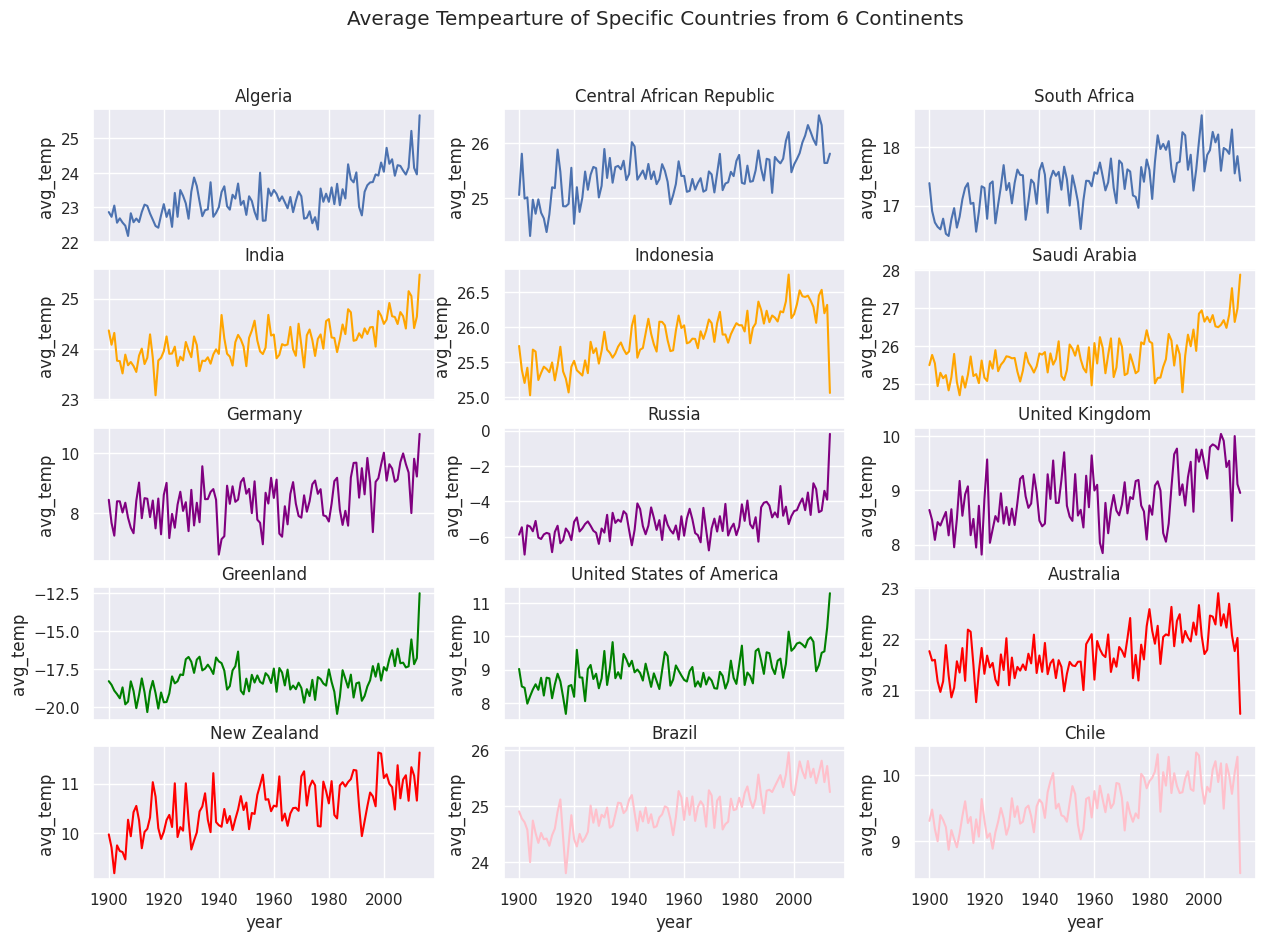

In [ ]:
#setup the subplot and create graph for each country
sns.set()
fig, axes = plt.subplots(5,3, figsize=(15, 10), sharex=True)
fig.suptitle("Average Tempearture of Specific Countries from 6 Continents")

#algeria
sns.lineplot(x= temp_africa[temp_africa.country == "Algeria"].year, y =temp_africa[temp_africa.country == "Algeria"].avg_temp, ax=axes[0][0])
axes[0][0].set_title("Algeria")

#Central African Republic
sns.lineplot(x= temp_africa[temp_africa.country == "Central African Republic"].year, y =temp_africa[temp_africa.country == "Central African Republic"].avg_temp, ax=axes[0][1])
axes[0][1].set_title("Central African Republic")

#South Africa
sns.lineplot(x= temp_africa[temp_africa.country == "South Africa"].year, y =temp_africa[temp_africa.country == "South Africa"].avg_temp, ax=axes[0][2])
axes[0][2].set_title("South Africa")

#Asia
#India
sns.lineplot(x= temp_asia[temp_asia.country == "India"].year, y =temp_asia[temp_asia.country == "India"].avg_temp, ax=axes[1][0], color="orange")
axes[1][0].set_title("India")

#Indonesia
sns.lineplot(x= temp_asia[temp_asia.country == "Indonesia"].year, y =temp_asia[temp_asia.country == "Indonesia"].avg_temp, ax=axes[1][1], color="orange")
axes[1][1].set_title("Indonesia")
#Saudi Arabia
sns.lineplot(x= temp_asia[temp_asia.country == "Saudi Arabia"].year, y =temp_asia[temp_asia.country == "Saudi Arabia"].avg_temp, ax=axes[1][2], color="orange")
axes[1][2].set_title("Saudi Arabia")


#EUROPE
#Germany
sns.lineplot(x= temp_europe[temp_europe.country == "Germany"].year, y =temp_europe[temp_europe.country == "Germany"].avg_temp, ax=axes[2][0], color="purple")
axes[2][0].set_title("Germany")
#Russia
sns.lineplot(x= temp_europe[temp_europe.country == "Russia"].year, y =temp_europe[temp_europe.country == "Russia"].avg_temp, ax=axes[2][1], color="purple")
axes[2][1].set_title("Russia")
#United Kingdom
sns.lineplot(x= temp_europe[temp_europe.country == "United Kingdom"].year, y =temp_europe[temp_europe.country == "United Kingdom"].avg_temp, ax=axes[2][2], color="purple")
axes[2][2].set_title("United Kingdom")

#NORTH AMERICA
#Greenland
sns.lineplot(x= temp_north_america[temp_north_america.country == "Greenland"].year, y =temp_north_america[temp_north_america.country == "Greenland"].avg_temp, ax=axes[3][0], color="green")
axes[3][0].set_title("Greenland")
#United States
sns.lineplot(x= temp_north_america[temp_north_america.country == "United States of America"].year, y =temp_north_america[temp_north_america.country == "United States of America"].avg_temp, ax=axes[3][1], color="green")
axes[3][1].set_title("United States of America")

#OCEANIA
#Australia
sns.lineplot(x= temp_oceania[temp_oceania.country == "Australia"].year, y =temp_oceania[temp_oceania.country == "Australia"].avg_temp, ax=axes[3][2], color="red")
axes[3][2].set_title("Australia")
#New Zealand
sns.lineplot(x= temp_oceania[temp_oceania.country == "New Zealand"].year, y =temp_oceania[temp_oceania.country == "New Zealand"].avg_temp, ax=axes[4][0], color="red")
axes[4][0].set_title("New Zealand")

#SOUTH AMERICA
#Brazil
sns.lineplot(x= temp_south_america[temp_south_america.country == "Brazil"].year, y =temp_south_america[temp_south_america.country == "Brazil"].avg_temp, ax=axes[4][1], color="pink")
axes[4][1].set_title("Brazil")
#Chile
sns.lineplot(x= temp_south_america[temp_south_america.country == "Chile"].year, y =temp_south_america[temp_south_america.country == "Chile"].avg_temp, ax=axes[4][2], color="pink")
axes[4][2].set_title("Chile")

plt.show()

#### **Observation**
There is an interesting trend in our plot. From initial observation, we can see an upward trend from 1980 onwards. Most notebaly, there is an average increase in temperature for most countries from 2000 onwards. United States, Greenland, Saudi Arabia, Algeria, and Russia had a sharp increase in their avg. temperature from 2010 onwards

### **2.1.4 Temperature Trend of Countries**

Lets find the hottest and coldest countries in world by their average temperature.

We will get the top 20 hottest country:

#### **Hottest Countries**

In [ ]:
#hottest countries in descending order of avg temp

top_20_hot_countries = temp_countries_yearly[["country", "avg_temp" ]].groupby("country")["avg_temp"].mean().reset_index().sort_values(by="avg_temp", ascending=False).head(15).copy()
top_20_hot_countries.reset_index(drop=True, inplace=True)
top_20_hot_countries

country   avg_temp
0                            Djibouti  28.885673
1                                Mali  28.615028
2                        Burkina Faso  28.284241
3                             Senegal  28.118683
4                               Aruba  28.104281
5                United Arab Emirates  27.871594
6                          Mauritania  27.790105
7                              Gambia  27.692663
8                               Niger  27.615232
9                             Curaçao  27.549154
10  Bonaire, Saint Eustatius And Saba  27.364756
11                              Benin  27.345622
12                              Palau  27.306609
13                               Chad  27.261496
14                      Palmyra Atoll  27.248114

Ranking the top 20 countries as a bar chart with their respective average temperature (for 1900-2013)

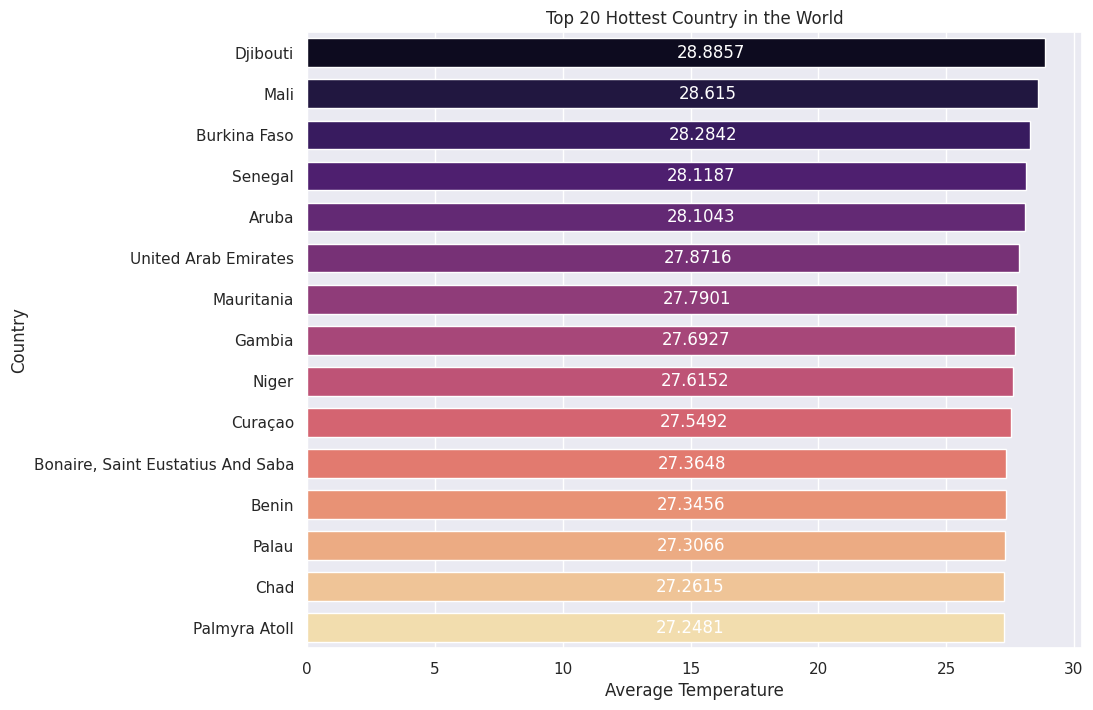

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.barplot(y=top_20_hot_countries.country, x=top_20_hot_countries.avg_temp, width=0.7, palette="magma")
ax.bar_label(ax.containers[0], label_type = 'center',padding=25, color="white")
ax.set_xlabel("Average Temperature")
ax.set_ylabel("Country")
ax.set_title("Top 20 Hottest Country in the World")
plt.show()


#### **Coldest Countries**

Lets get the top 20 coldest countries by their average temperature

In [ ]:
#coldest countries in descending order of avg temp

top_20_cold_countries = temp_countries_yearly[["country", "avg_temp" ]].groupby("country")["avg_temp"].mean().reset_index().sort_values(by="avg_temp", ascending=True).head(15).copy()
top_20_cold_countries.reset_index(drop=True, inplace=True)
top_20_cold_countries

country   avg_temp
0                                      Greenland -18.152097
1                         Svalbard and Jan Mayen  -7.051755
2                                         Russia  -5.140921
3                                        Denmark  -4.740715
4                                         Canada  -4.736779
5                                       Mongolia  -0.498365
6                                         Norway   0.488553
7   South Georgia and the South Sandwich Islands   1.432852
8                                        Iceland   1.789179
9                                  North America   2.452538
10             Heard Island and McDonald Islands   2.579286
11                                        Sweden   2.768794
12                                    Kyrgyzstan   3.508410
13                                       Finland   3.671952
14                                    Tajikistan   4.289327

Ranking the top 20 coldest countries as a bar chart with their respective average temperature (for 1900-2013)

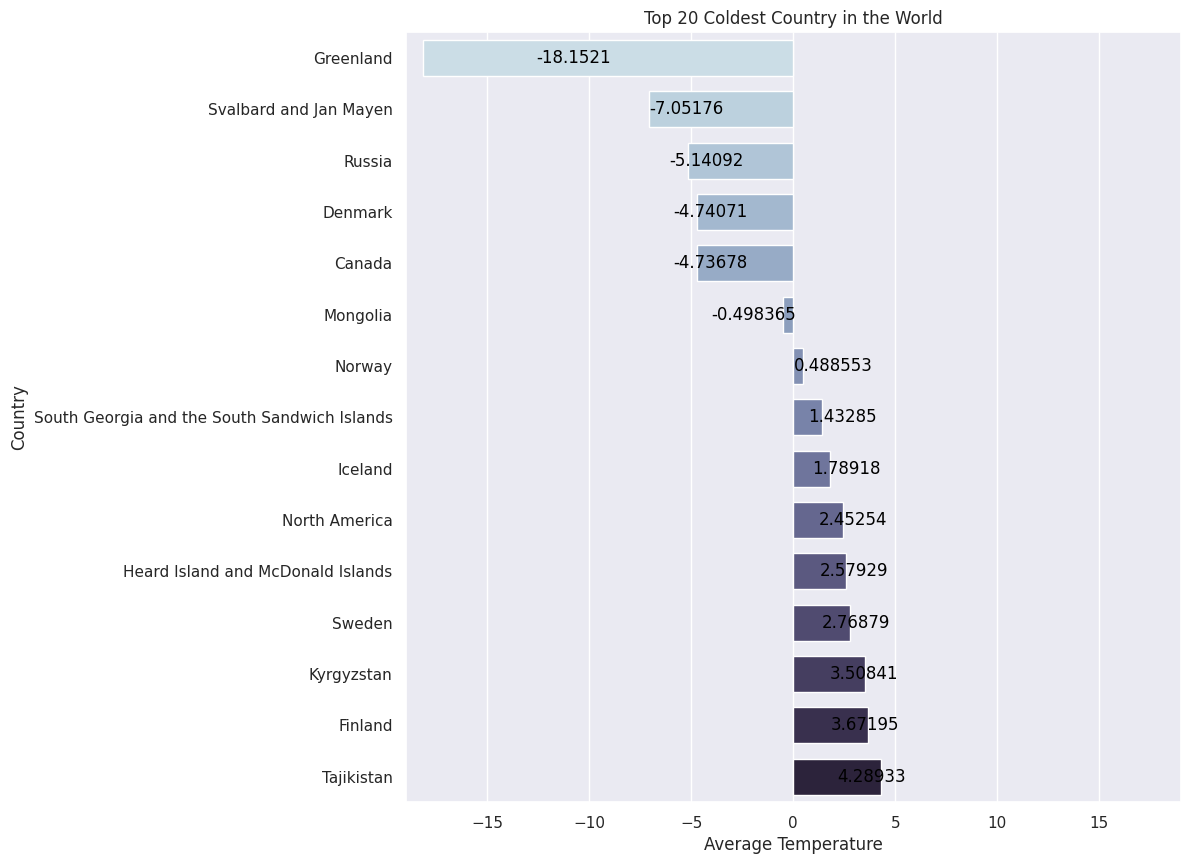

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.barplot(y=top_20_cold_countries.country, x=top_20_cold_countries.avg_temp, width=0.7, palette="ch:s=.25,rot=-.25")
ax.bar_label(ax.containers[0], label_type = 'center',padding=25, color="black")
ax.set_xlim(-19,19)
ax.set_xlabel("Average Temperature")
ax.set_ylabel("Country")
ax.set_title("Top 20 Coldest Country in the World")
plt.show()

## **2.2 Exploring The Disaster Data**

We will clean the data a little and remove all the unwanted columns and store the data into a new variable geo_disasters_clean.

We will choose the columns to drop based on either their redunancy, significance, or nullness.

Our first goal is to see the total number of each kind of disaster in our dataset.

### **2.2.1 Types of Disaster**

In [ ]:
geo_disasters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37096 entries, 0 to 39952
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            37096 non-null  object 
 1   country       37096 non-null  object 
 2   iso3          36802 non-null  object 
 3   gwno          36696 non-null  float64
 4   year          37096 non-null  int64  
 5   geo_id        37096 non-null  int64  
 6   geolocation   37096 non-null  object 
 7   level         37096 non-null  int64  
 8   adm1          37096 non-null  object 
 9   adm2          12555 non-null  object 
 10  adm3          2107 non-null   object 
 11  location      37096 non-null  object 
 12  historical    37096 non-null  int64  
 13  hist_country  173 non-null    object 
 14  disastertype  37096 non-null  object 
 15  disasterno    37096 non-null  object 
 16  latitude      37096 non-null  float64
 17  longitude     37096 non-null  float64
 18  is_tropical   37096 non-null  i

In [ ]:
geo_disasters.head(3)

id  country iso3   gwno  year  geo_id  geolocation  level     adm1   
0  109  Albania  ALB  339.0  2009     346  Ana E Malit      3  Shkoder  \
1  109  Albania  ALB  339.0  2009     351       Bushat      3  Shkoder   
2  175   Angola  AGO  540.0  2001     760       Onjiva      3   Cunene   

       adm2  ...     location historical  hist_country disastertype   
0  Shkodres  ...  Ana E Malit          0           NaN        flood  \
1  Shkodres  ...       Bushat          0           NaN        flood   
2  Cuanhama  ...       Onjiva          0           NaN        flood   

  disasterno   latitude  longitude  is_tropical  is_northern  is_southern  
0  2009-0631  42.020948  19.418317            0            1            0  
1  2009-0631  41.959294  19.514309            0            1            0  
2  2001-0146 -17.093484  15.665758            1            0            0  

[3 rows x 21 columns]

In [ ]:
print("Number of different disaster levels: ", geo_disasters.level.unique(), "\n")
print("Number of different historical values: ", geo_disasters.historical.unique(), "\n")
print("Different kinds of disaster types: ", geo_disasters.disastertype.unique(), "\n")
print("Number of countries in our data: ", len(geo_disasters.country.unique()), "\n")
print("Number of geolocations in our data: ", len(geo_disasters.geolocation.unique()), "\n")

Number of different disaster levels:  [3 2 1] 

Number of different historical values:  [0 1] 

Different kinds of disaster types:  ['flood' 'storm' 'extreme temperature ' 'landslide' 'drought'] 

Number of countries in our data:  197 

Number of geolocations in our data:  9239 



In [ ]:
#Transform the data to drop unwanted columns
drop_labels = ["iso3", "gwno", "adm1", "adm2", "adm3", "location", "hist_country", "geo_id", "disasterno", "historical"]
geo_disasters_clean = geo_disasters.drop(labels=drop_labels, axis=1)
geo_disasters_clean.head(3)

id  country  year  geolocation  level disastertype   latitude  longitude   
0  109  Albania  2009  Ana E Malit      3        flood  42.020948  19.418317  \
1  109  Albania  2009       Bushat      3        flood  41.959294  19.514309   
2  175   Angola  2001       Onjiva      3        flood -17.093484  15.665758   

   is_tropical  is_northern  is_southern  
0            0            1            0  
1            0            1            0  
2            1            0            0

In [ ]:
total_count_disasters = geo_disasters_clean.groupby("disastertype")[["country"]].count().reset_index().rename(columns={"country": "count"})

total_count_disasters

disastertype  count
0               drought   2938
1  extreme temperature    3506
2                 flood  17347
3             landslide    982
4                 storm  12323

#### **Visualizing Number of Disasters**

The data showed that the leading disaster types are flood and storms.

Extreme temperature, drought, and earthquake have occurred at almost similar rate.

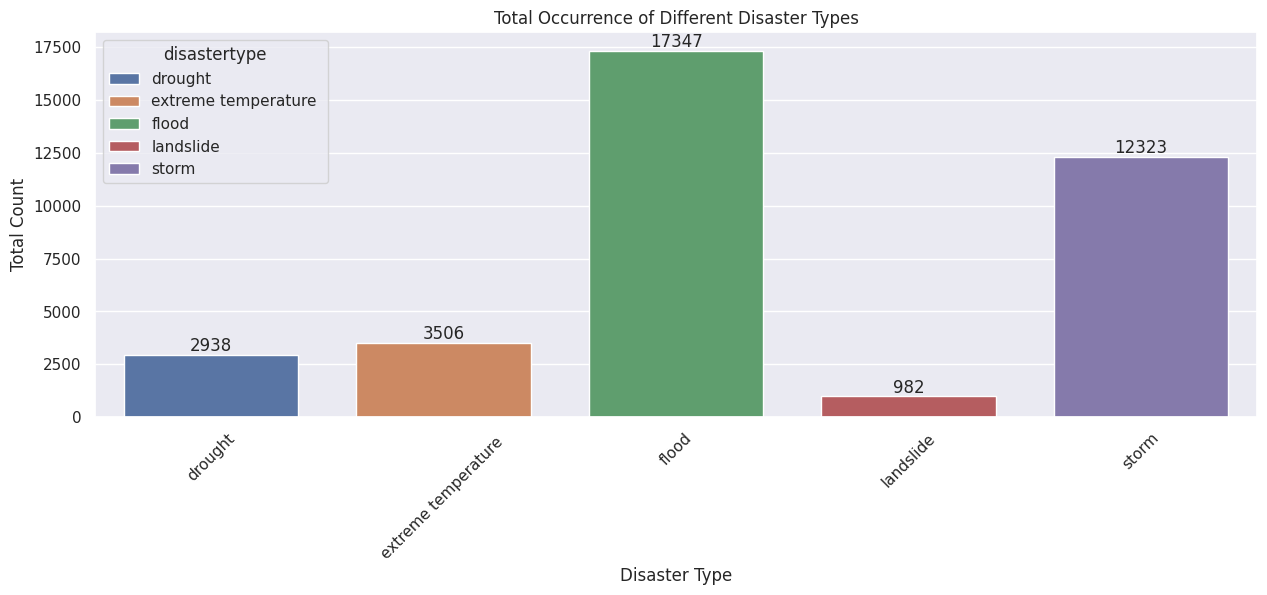

In [ ]:
#plot the occurrence of each disaster type
plt.figure(figsize=(15,5))
axes = sns.barplot(data=total_count_disasters, x="disastertype", y="count", hue="disastertype", width=0.75, dodge=False)
for bars in axes.containers:
  axes.bar_label(bars)
axes.set_xlabel("Disaster Type")
axes.set_ylabel("Total Count")
axes.set_title("Total Occurrence of Different Disaster Types")
plt.xticks(rotation=45)
plt.show()


### **2.2.2 Compare Temperature and Disaster**

Let us see if there is any relationship between the change in temperature over the years and the occurence of disasters.

For the comparions, we will use the global tempraure dataset and we will create a new dataframe called geo_disasters_yearly to see the total number of disasters per year. Additionally, we will clean the global data and store it as temp_global_clean.

Because the range for the two dataframe are different, we will limit our data year from 1960 to 2015.

In [ ]:
#create a new dataframe to get number of disasters per year

geo_disasters_yearly = geo_disasters_clean.groupby(by="year")[["disastertype"]].count().reset_index().rename(columns={"disastertype":"count"})

print(geo_disasters_yearly.year.min())
print(geo_disasters_yearly.year.max())

1960
2018


In [ ]:
#clean the global temp data to get only the columns and data needed
# and rename the dt to year
temp_global_clean = temp_global[["dt", "LandAndOceanAverageTemperature", "LandAndOceanAverageTemperatureUncertainty", "LandAverageTemperature"]].copy()
temp_global_clean.dt = pd.to_datetime(temp_global_clean.dt).dt.year
temp_global_clean.rename(columns={"dt":"year"}, inplace=True)
temp_global_clean.dropna(inplace=True)

print(temp_global_clean.year.min())
print(temp_global_clean.year.max())


1850
2015


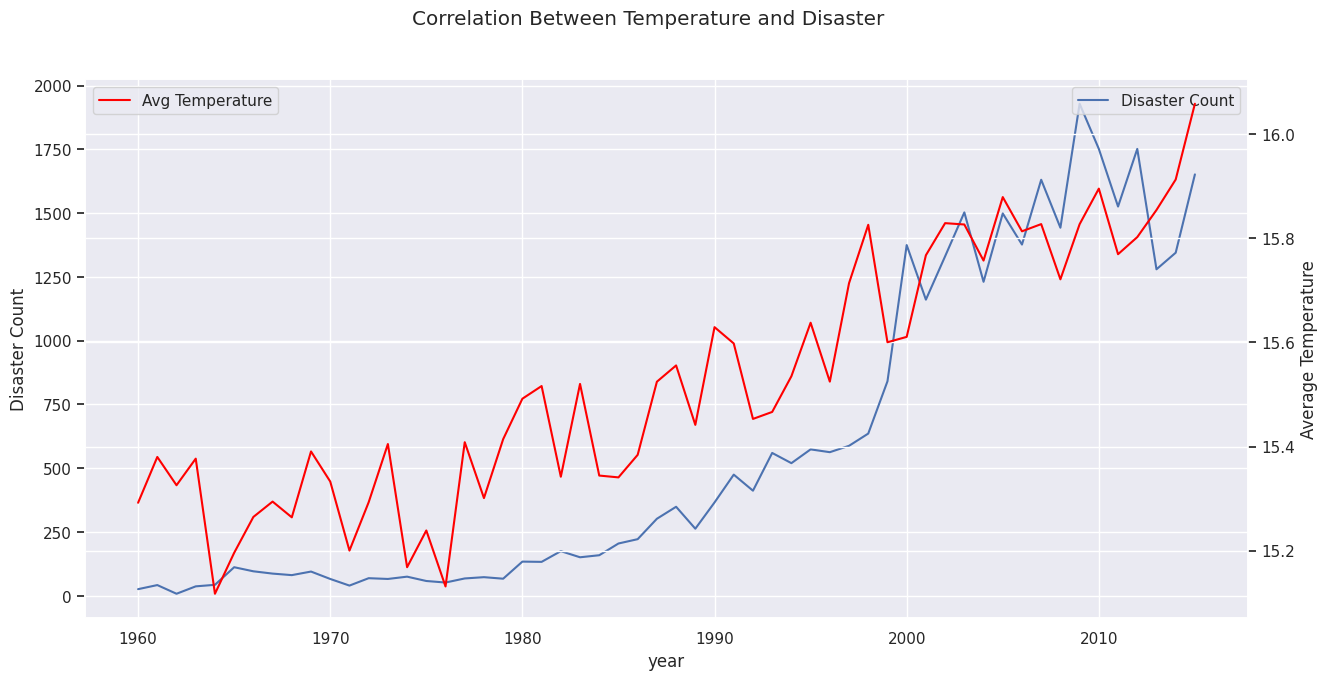

In [ ]:
# limiting the range of year to 1960-2015 in order to compensate for the range diference between the two dataset.

geo_disasters_limited = geo_disasters_yearly[geo_disasters_yearly.year.between(1960, 2015)].copy()
temp_global_clean_limited = temp_global_clean[temp_global_clean.year.between(1960, 2015)].copy()
temp_global_clean_limited = temp_global_clean_limited.groupby("year").mean().reset_index()


fig, axes = plt.subplots(figsize=(15, 7))
fig.suptitle("Correlation Between Temperature and Disaster")
ax2=axes.twinx()

# sns.lineplot(x= temp_global_clean_limited.year, y =temp_global_clean_limited.LandAndOceanAverageTemperature)
sns.lineplot(data=geo_disasters_limited, x="year", y="count", ax=axes)
axes.set_ylabel("Disaster Count")
axes.legend(["Disaster Count"], loc="upper right")
sns.lineplot(data=temp_global_clean_limited, x="year", y="LandAndOceanAverageTemperature", ax=ax2, color="red")
ax2.set_ylabel("Average Temperature")
ax2.legend(["Avg Temperature"], loc="upper left")
plt.show()


#### **Observation**

From the graph above, we can clearly see an overlapping trend between the disaster count and the global average temperature. There is an increase that is noticed after the year 1990, and a pronounced difference from 2000 onwards compared to the previous years.

Although, the cause and effect relation can be debated as many different factors needs to be considered. We can clearly see an increase in number of disaster as the global average temperature is increasing.

### **2.2.3 Disaster Data For Hot Countries**

Based on our previous data exploration we have a list of top 20 hottest countries. In this section, we will explore the disaster data for the top five hottest countries. From initial review, we are missing data for Aruba and UAE so will exlude those 2 from our analysis.

We will plot the ccountry's disaster count as a barplot next to a lineplot of their average temp. The average temperature data will be limited to the range of year within our disaster data.

In [ ]:
#geo_disasters_clean
hot_countries = top_20_hot_countries.country.unique()


#lets get the disaster data for hot countries

geo_disasters_hot = geo_disasters_clean[geo_disasters_clean.country.isin(hot_countries)].copy()

geo_disasters_hot.drop(["id", "level", "latitude", "longitude"], axis=1, inplace=True)
geo_disasters_hot  = geo_disasters_hot.groupby(by=["country", "year","disastertype"]).count().reset_index()

geo_disasters_hot = geo_disasters_hot.sort_values(by=["country", "year", "disastertype"]).rename(columns={"geolocation":"disaster_count"})

list(top_20_hot_countries.country)

['Djibouti',
 'Mali',
 'Burkina Faso',
 'Senegal',
 'Aruba',
 'United Arab Emirates',
 'Mauritania',
 'Gambia',
 'Niger',
 'Curaçao',
 'Bonaire, Saint Eustatius And Saba',
 'Benin',
 'Palau',
 'Chad',
 'Palmyra Atoll']

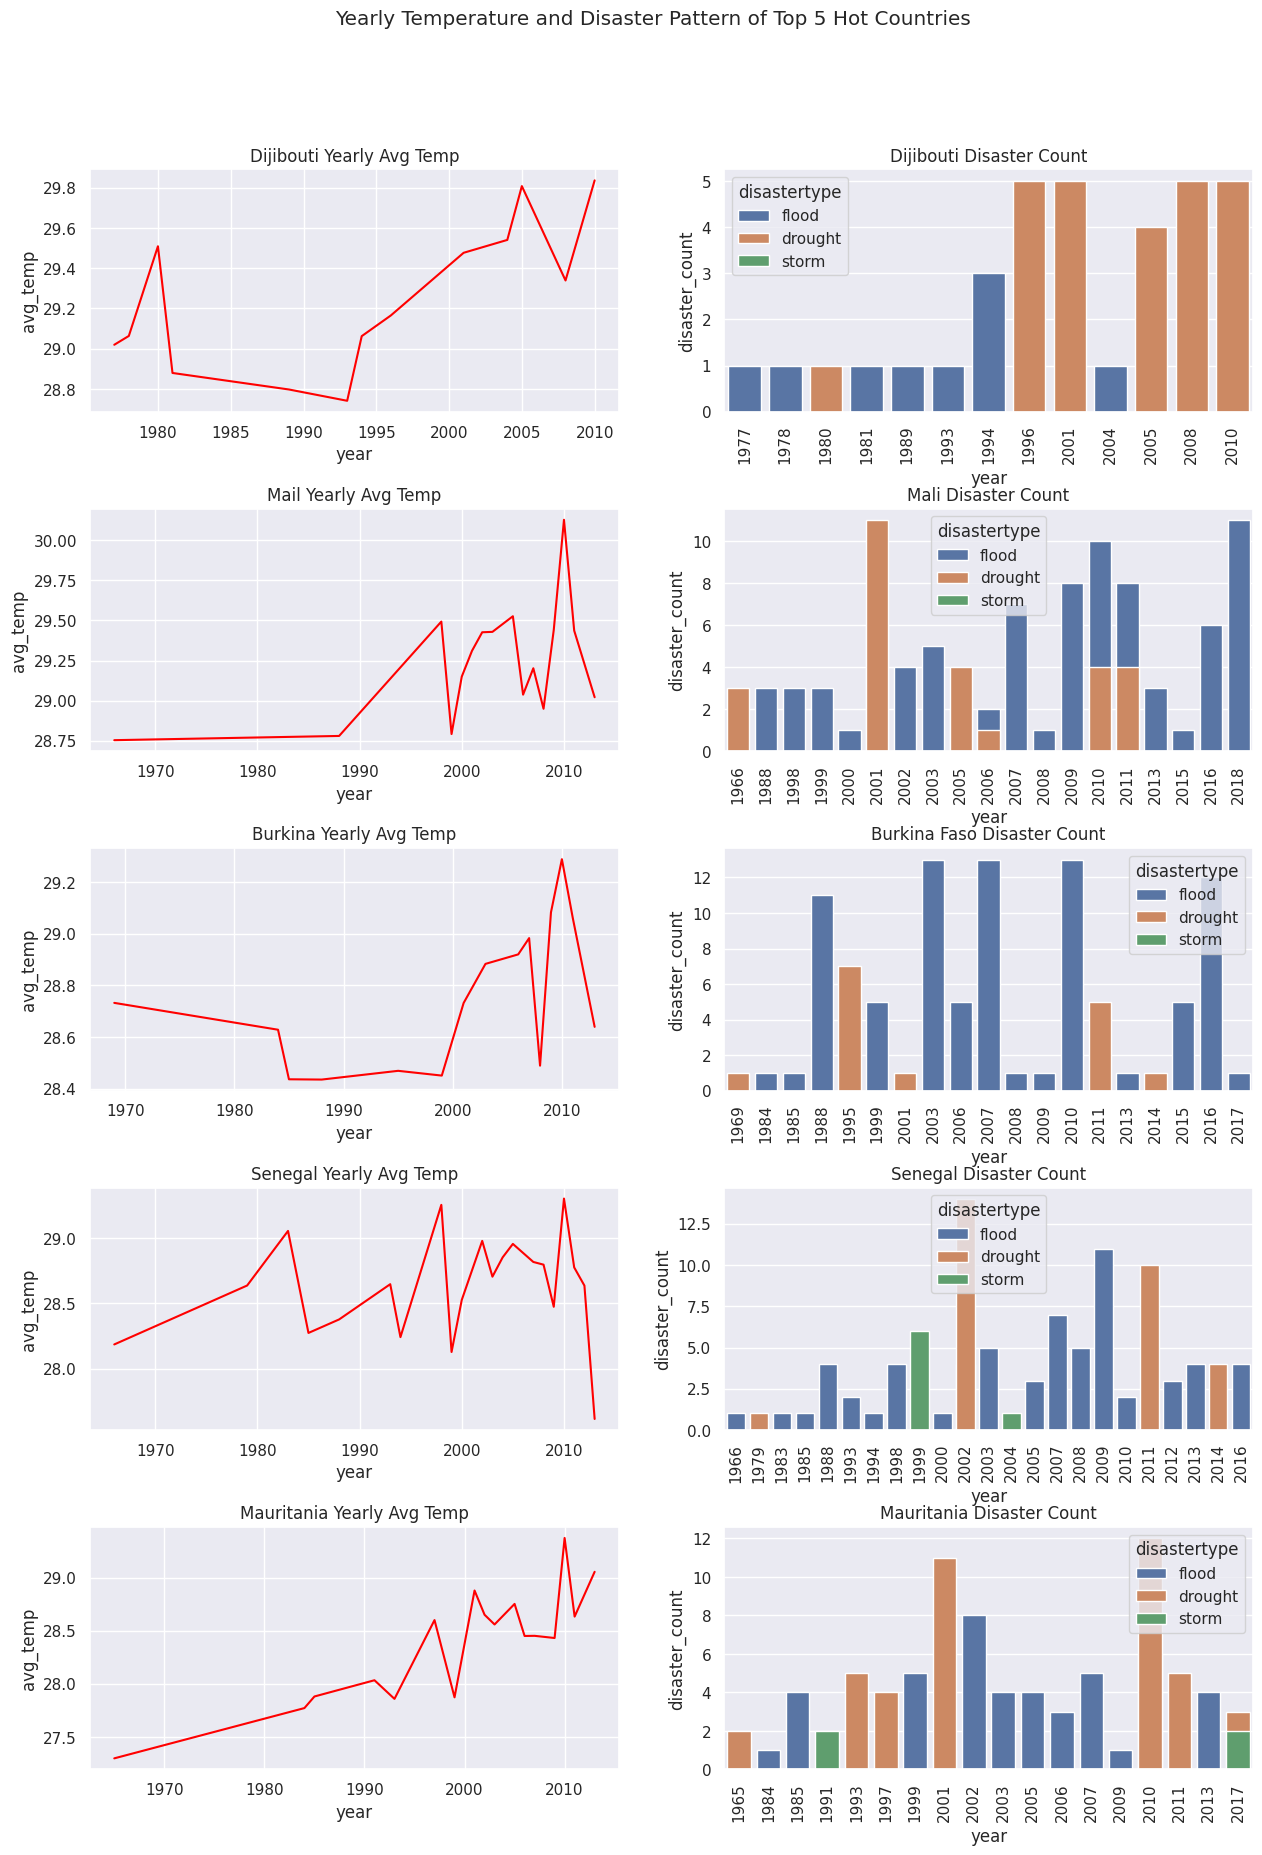

In [ ]:
# Get the temp Data for countries based of the years from their disaster data

#djibouti
year_list_djibouti = list(geo_disasters_hot[geo_disasters_hot.country == "Djibouti"].year)
djibouti_temp = temp_countries_yearly[(temp_countries_yearly.country == "Djibouti") & (temp_countries_yearly.year.isin(year_list_djibouti))].copy()


#mali
year_list_mali = list(geo_disasters_hot[geo_disasters_hot.country == "Mali"].year)
mali_temp = temp_countries_yearly[(temp_countries_yearly.country == "Mali") & (temp_countries_yearly.year.isin(year_list_mali))].copy()


#Burkina Faso
year_list_burkina = list(geo_disasters_hot[geo_disasters_hot.country == "Burkina Faso"].year)
burkina_temp = temp_countries_yearly[(temp_countries_yearly.country == "Burkina Faso") & (temp_countries_yearly.year.isin(year_list_burkina))].copy()
burkina_temp
#Senegal
year_list_senegal = list(geo_disasters_hot[geo_disasters_hot.country == "Senegal"].year)
senegal_temp = temp_countries_yearly[(temp_countries_yearly.country == "Senegal") & (temp_countries_yearly.year.isin(year_list_senegal))].copy()
senegal_temp

#Aruba and UAE skipped due to lack of data

#Mauritania
year_list_mauritania = list(geo_disasters_hot[geo_disasters_hot.country == "Mauritania"].year)
mauritania_temp = temp_countries_yearly[(temp_countries_yearly.country == "Mauritania") & (temp_countries_yearly.year.isin(year_list_mauritania))].copy()



## Avg Temp and Disaster Count of top 5 hot countries
fig, axes = plt.subplots(5,2, figsize=(15,20))
fig.suptitle("Yearly Temperature and Disaster Pattern of Top 5 Hot Countries")

plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.2,hspace=0.4)
hue_order=['flood', 'drought', 'storm']

dji_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Djibouti"], x="year", y="disaster_count", hue="disastertype", hue_order=hue_order, ax=axes[0][1], dodge=False).set_title("Dijibouti Disaster Count")
dji_temp = sns.lineplot(data=djibouti_temp, x="year", y="avg_temp", ax=axes[0][0], color="red").set_title("Dijibouti Yearly Avg Temp")

mali_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Mali"], x="year", y="disaster_count", hue="disastertype", hue_order=hue_order, ax=axes[1][1], dodge=False).set_title("Mali Disaster Count")
mali_temp = sns.lineplot(x=mali_temp.year, y=mali_temp.avg_temp, ax=axes[1][0], color="red").set_title("Mail Yearly Avg Temp")


burkina_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Burkina Faso"], x="year", y="disaster_count", hue="disastertype", hue_order=hue_order, ax=axes[2][1], dodge=False).set_title("Burkina Faso Disaster Count")
burkina_temp = sns.lineplot(x=burkina_temp.year, y=burkina_temp.avg_temp, ax=axes[2][0], color="red").set_title("Burkina Yearly Avg Temp")


senegal_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Senegal"], x="year", y="disaster_count", hue="disastertype",hue_order=hue_order, ax=axes[3][1], dodge=False).set_title("Senegal Disaster Count")
senegal_temp = sns.lineplot(x=senegal_temp.year, y=senegal_temp.avg_temp, ax=axes[3][0], color="red").set_title("Senegal Yearly Avg Temp")

mauritania_disas = sns.barplot(data=geo_disasters_hot[geo_disasters_hot.country == "Mauritania"], x="year", y="disaster_count", hue="disastertype", hue_order=hue_order, ax=axes[4][1], dodge=False).set_title("Mauritania Disaster Count")
mauritania_temp = sns.lineplot(x=mauritania_temp.year, y=mauritania_temp.avg_temp, ax=axes[4][0], color="red").set_title("Mauritania Yearly Avg Temp")

for i in range(5):
  axes[i][1].tick_params(axis='x', labelrotation=90)

plt.show()

In [ ]:
hot_countries_disaster_count =geo_disasters_hot.groupby(by=["disastertype"]).count()
hot_countries_disaster_count

country  year  disaster_count  is_tropical  is_northern   
disastertype                                                            
drought            43    43              43           43           43  \
flood             123   123             123          123          123   
storm              14    14              14           14           14   

              is_southern  
disastertype               
drought                43  
flood                 123  
storm                  14

#### **Observation**

One aspect which stands out from the data is that the disaster type for hottest countries are mostly flood and drought. This is in contrast to the leading global disaster type which were flood and storms.

## **2.3 Precipitation Data**



## New Section

In [ ]:
selected_columns = ['Jan record high C', 'Feb record high C', 'Mar record high C', 'Apr record high C', 'May record high C',
                    'Jun record high C', 'Jul record high C', 'Aug record high C', 'Sep record high C', 'Oct record high C',
                    'Nov record high C', 'Dec record high C']
wiki_climate['average_high_temp'] = wiki_climate[selected_columns].mean(axis = 1)
wiki_climate = wiki_climate.dropna(subset=['location'])

In [ ]:
wiki_climate = wiki_climate.reset_index().sort_values(by="average_high_temp", ascending=False).head(20).round(2)
wiki_climate.reset_index(drop=True, inplace=True)
wiki_climate

index                                           location   
0    5538        Timbuktu (1950–2000, extremes 1897–present)  \
1     393                                              Mecca   
2    2249          Atbara (1961–1990, extremes 1943–present)   
3    1439                                       Aswan, Egypt   
4     532       N'Djamena (1961–1990, extremes 1904–present)   
5     428                                Al Ahsa (1985–2010)   
6    3451                                  Indio, California   
7    1022         Kassala (1961–1990, extremes 1901–present)   
8    6885                              La Quinta, California   
9    1710                                        Qena, Egypt   
10   4853  Palm Springs Fire Station 2, California (1981–...   
11   4620  Palm Desert, California, elev. {{convert|10|ft...   
12   5101          Coachella, California (1981–2010 normals)   
13   6563     Palm Springs Int'l Airport (1981–2010 normals)   
14    757                                             Muscat   
15    115                               Khartoum (1971–2000)   
16    213                                 Jeddah (1985-2010)   
17    620  Hermosillo, Sonora (1981–2010, extremes (1973-...   
18   8629                                       Imperial, CA   
19    773           Al Ain International Airport (1995–2017)   

    Jan record high C  Feb record high C  Mar record high C   
0                41.6               43.5               46.1  \
1                37.4               38.3               42.4   
2                41.0               42.0               45.7   
3                35.3               38.5               44.0   
4                41.8               47.6               46.5   
5                32.7               37.8               41.2   
6                36.1               37.8               40.0   
7                41.7               43.5               45.3   
8                36.1               37.8               39.4   
9                33.0               37.0               43.0   
10               35.0               37.2               40.0   
11               36.1               37.8               39.4   
12               35.0               37.2               40.0   
13               35.0               37.2               40.0   
14               34.6               38.2               41.5   
15               39.7               42.5               45.2   
16               35.0               36.0               40.2   
17               35.0               38.0               41.5   
18               35.6               35.6               40.0   
19               31.8               36.6               42.9   

    Apr record high C  May record high C  Jun record high C   
0                48.9               49.0               49.0  \
1                44.7               49.4               49.6   
2                47.1               47.5               47.7   
3                46.1               47.8               50.6   
4                48.3               49.1               44.0   
5                45.0               49.0               50.6   
6                43.3               49.4               50.6   
7                46.0               47.0               47.6   
8                42.8               47.2               50.6   
9                46.0               50.0               50.0   
10               44.4               46.7               50.0   
11               42.8               47.2               50.6   
12               44.4               46.7               49.4   
13               44.4               46.7               49.4   
14               44.9               48.3               48.5   
15               46.2               46.8               46.3   
16               44.5               48.2               52.0   
17               44.0               46.0               49.5   
18               42.8               47.8               50.6   
19               44.4               49.3               49.0   

    Jul rec

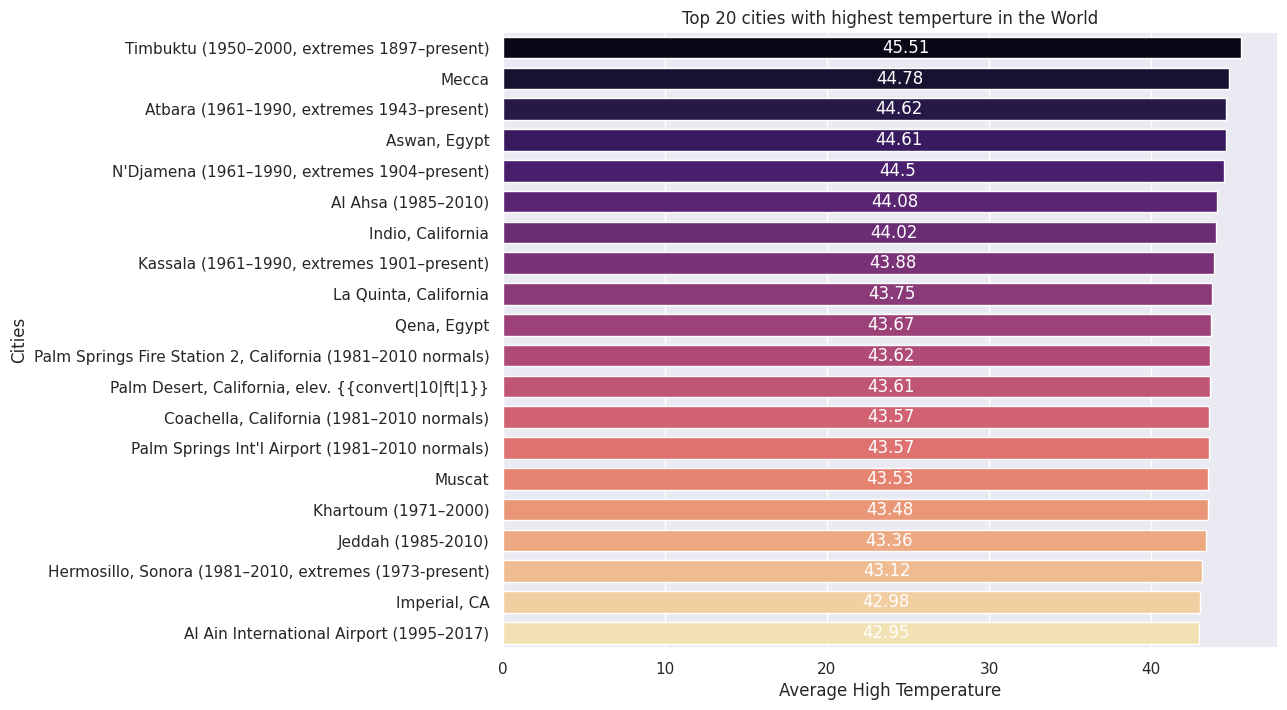

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.barplot(y=wiki_climate.location, x=wiki_climate.average_high_temp, width=0.7, palette="magma")
ax.bar_label(ax.containers[0], label_type = 'center',padding=25, color="white")
ax.set_xlabel("Average High Temperature")
ax.set_ylabel("Cities")
ax.set_title("Top 20 cities with highest temperture in the World")
plt.show()

## **2.4 Time Series Analysis: Temperature Data**

#### **2.3.1 Seasonality & Trend of USA Temp Data**

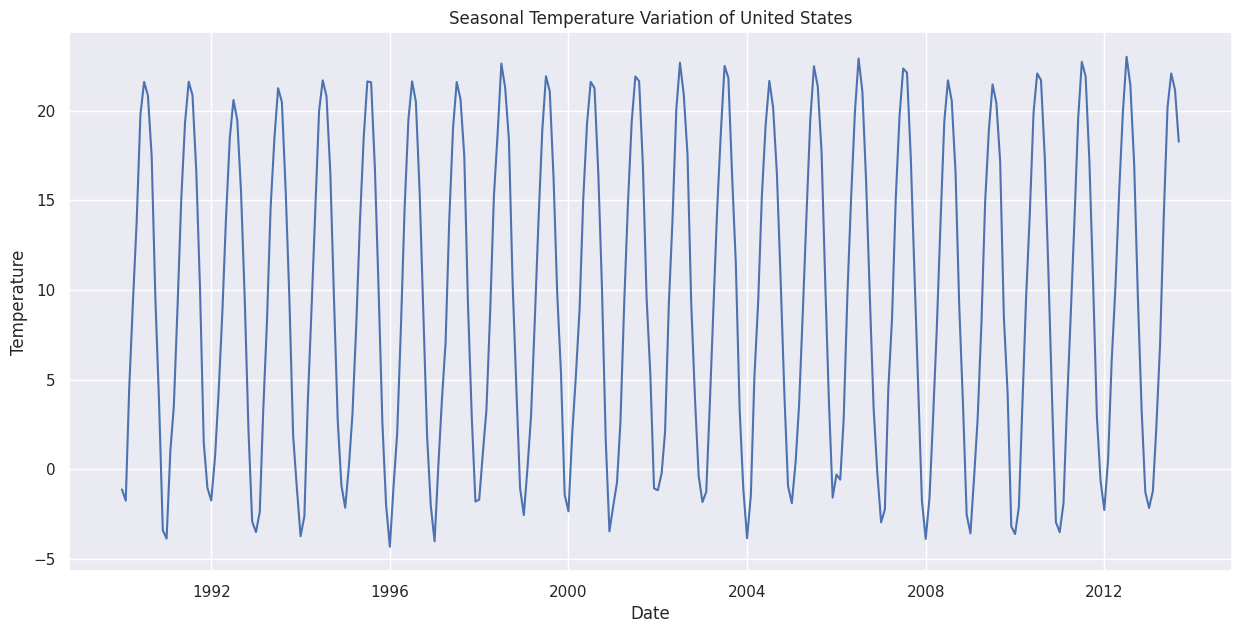

In [ ]:
#get USA temp data

united_states_temp = temp_countries.query("country == 'United States of America'").copy()

united_states_temp.drop("avg_temp_uncertainty", axis=1, inplace=True)
united_states_temp.dt = pd.to_datetime(united_states_temp.dt)

# us temp data from 1950-2014
united_states_temp_limited = united_states_temp[pd.DatetimeIndex(united_states_temp.dt).year.isin(range(1990,2014))]


plt.figure(figsize=(15,7))
us_plot = sns.lineplot(x=united_states_temp_limited.dt, y=united_states_temp_limited.avg_temp)
us_plot.set_xlabel("Date")
us_plot.set_ylabel("Temperature")
us_plot.set_title("Seasonal Temperature Variation of United States")
plt.show()


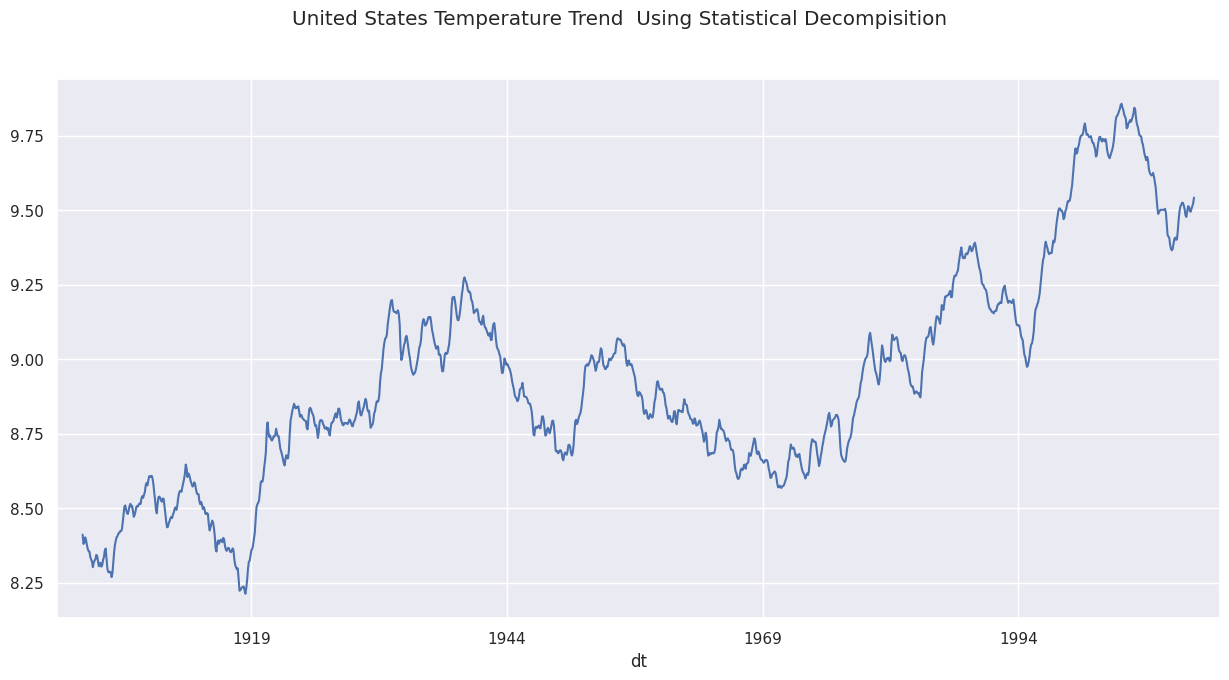

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Trend using Statistical decomposition using moving averages.

import statsmodels.api as sm
from matplotlib import rcParams

us_decompose = united_states_temp[["dt", "avg_temp"]].set_index(united_states_temp.dt).drop(["dt"], axis=1)

plt.figure(figsize=(15,7))
plt.suptitle("United States Temperature Trend  Using Statistical Decompisition")
decomposition = sm.tsa.seasonal_decompose(us_decompose, period=60)
us_decompose_plot = decomposition.trend.plot()

plt.show()

In [ ]:
# result =  seasonal_decompose(us_decompose, model="additive",period=120)
# x = result.plot()
# plt.show()

### **2.3.2 USA Monthly Trend 1990-2013**

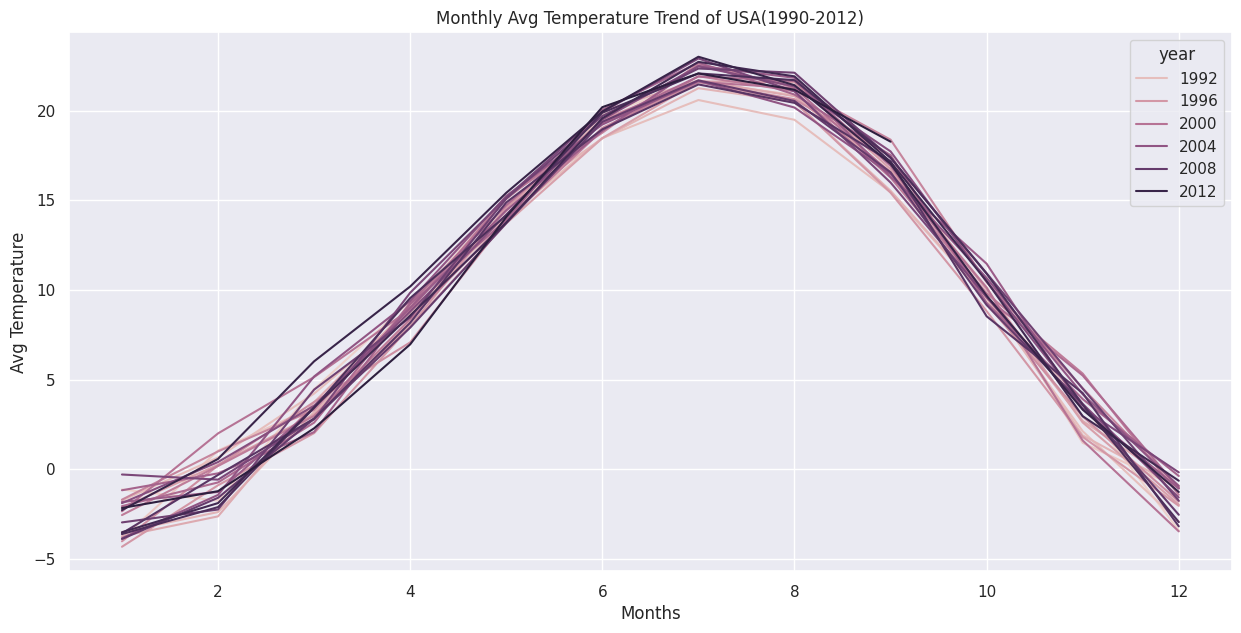

In [ ]:
# seeing monthly trend in temperature every year
united_states_temp['month'] = united_states_temp.dt.dt.month
united_states_temp['year'] = united_states_temp.dt.dt.year
plt.figure(figsize=(15,7))
monthly_plot = sns.lineplot(data=united_states_temp[united_states_temp.year.between(1990,2013)], x="month", y="avg_temp", hue="year")
monthly_plot.set_xlabel("Months")
monthly_plot.set_ylabel("Avg Temperature")
monthly_plot.set_title("Monthly Avg Temperature Trend of USA(1990-2012)")
plt.show()

### **2.3.3 Monthly Temperature Trend of Hemisphere**

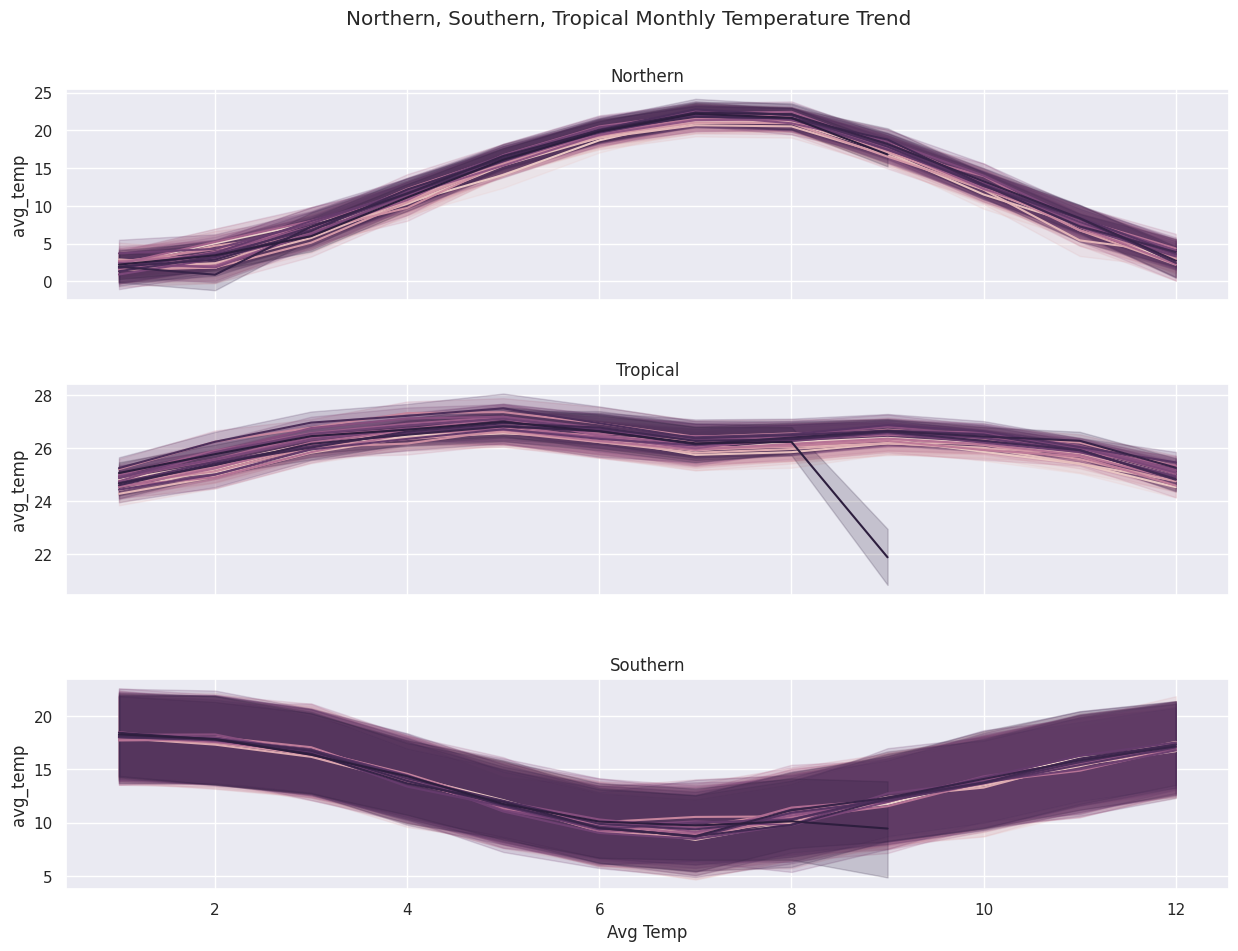

In [ ]:
temp_countries_new = temp_countries.copy()
temp_countries_new.dt = pd.to_datetime(temp_countries_new.dt)
temp_countries_new['year'] = temp_countries_new.dt.dt.year
temp_countries_new['month'] = temp_countries_new.dt.dt.month
temp_countries_tropical = temp_countries_new[temp_countries_new.is_tropical == 1]
temp_countries_northern = temp_countries_new[temp_countries_new.is_northern == 1]
temp_countries_southern = temp_countries_new[temp_countries_new.is_southern == 1]



fig, ax1 = plt.subplots(3,1,figsize=(15, 10), sharex=True)
fig.suptitle("Northern, Southern, Tropical Monthly Temperature Trend")
plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.2,hspace=0.4)

sns.lineplot(data=temp_countries_tropical[temp_countries_tropical.year.between(1990,2013)], x="month", y="avg_temp", hue="year", ax=ax1[1], legend=False).set(title="Tropical",xlabel="Avg Temp")

sns.lineplot(data=temp_countries_northern[temp_countries_northern.year.between(1990,2013)], x="month", y="avg_temp", hue="year", ax=ax1[0], legend=False).set(title="Northern",xlabel="Avg Temp")

sns.lineplot(data=temp_countries_southern[temp_countries_southern.year.between(1990,2013)], x="month", y="avg_temp", hue="year", ax=ax1[2], legend=False).set(title="Southern",xlabel="Avg Temp")

plt.show()

### **2.4.4 Statistical t-test**


In [ ]:
### perform paired t-test for two different time periods of average temperature


In [ ]:
# global and united states data
print(temp_global_clean_limited.columns)
print(united_states_temp.columns)
united_states_temp_arima = united_states_temp[['dt', 'avg_temp']].copy()
united_states_temp_arima = united_states_temp_arima.set_index('dt')

united_states_temp_arima.shape[0]

Index(['year', 'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty', 'LandAverageTemperature'],
      dtype='object')
Index(['dt', 'avg_temp', 'country', 'latitude', 'longitude', 'is_tropical',
       'is_northern', 'is_southern', 'month', 'year'],
      dtype='object')


1365

In [ ]:
#perform ADF to see if data is stationary or non stationary #uniteds states


from statsmodels.tsa.stattools import adfuller, acf, pacf

dftest = adfuller(united_states_temp_arima.avg_temp,autolag="AIC")

dfoutput = pd.Series(dftest[0:4], index=["Test Stats", "p-value", "Lags", "observations"])
for key, value in dftest[4].items():
    dfoutput[f"Critical Value ({key})"] = value
print("Results of Dickey-Fuller Test:\n")
print(dfoutput)



Results of Dickey-Fuller Test:

Test Stats                -3.532340
p-value                    0.007194
Lags                      24.000000
observations            1340.000000
Critical Value (1%)       -3.435239
Critical Value (5%)       -2.863699
Critical Value (10%)      -2.567920
dtype: float64


For the united_states_temp data series we get the p-value of 0.007194. Because the p-value of < 0.05 indicate that we reject the null hypothesis, the data is stationary.


In [ ]:
# for usa

#paired p test between the early temperature from 1930 - 1971 compared to late temperature from 1971 to 2012

# chose this range to have consistent number of temp records in both groups


from scipy import stats
usa_early_temp = united_states_temp[united_states_temp.year.between(1931,1971)]
usa_early_temp = usa_early_temp[['dt','avg_temp']].copy()
usa_late_temp = united_states_temp[united_states_temp.year.between(1972,2012)]
usa_late_temp = usa_late_temp[['dt','avg_temp']].copy()
# print(usa_late_temp.shape)
# print(usa_early_temp.shape)

usa_late_temp_list = list(usa_late_temp.avg_temp)
usa_early_temp_list = list(usa_early_temp.avg_temp)

paired_p_result_usa = stats.ttest_rel(usa_early_temp_list, usa_late_temp_list)
print("Statistical paired t-test for usa temp data: ",paired_p_result_usa)
print("p-value = %.10f" % paired_p_result_usa.pvalue)


# the p value is less than the 0.05 therefore there is significant difference between the temp in the early years compared to the temp data in the later years
# null hypothesis "there is no difference in the values from the early years and the later years" is rejected.


Statistical paired t-test for usa temp data:  TtestResult(statistic=-6.06668322657948, pvalue=2.6106444504633826e-09, df=491)
p-value = 0.0000000026


In [ ]:
#global

temp_global_clean_limited2 = temp_global_clean[temp_global_clean.year.between(1930, 2013)].copy()
temp_global_clean_limited2 = temp_global_clean_limited2.groupby("year").mean().reset_index()

temp_global_clean_limited2

global_early = temp_global_clean_limited2[temp_global_clean_limited2.year.between(1930,1971)]
global_late = temp_global_clean_limited2[temp_global_clean_limited2.year.between(1972,2013)]

# print(global_early.shape)
# print(global_late.shape)

global_early_temp = list(global_early.LandAndOceanAverageTemperature)
global_late_temp = list(global_late.LandAndOceanAverageTemperature)

paired_p_result_global = stats.ttest_rel(global_early_temp,global_late_temp)
print("Statistical paired t-test for global temp data: ",paired_p_result_global)
print("p-value = %.10f" % paired_p_result_global.pvalue)


# the p value is less than the 0.05 therefore there is significant difference between the temp in the early years compared to the temp data in the later years
# null hypothesis "there is no difference in the values from the early years and the later years" is rejected.

Statistical paired t-test for global temp data:  TtestResult(statistic=-9.016766026261084, pvalue=2.7943677733554206e-11, df=41)
p-value = 0.0000000000


In [ ]:
united_states_temp[['dt','avg_temp']]



dt  avg_temp
316218 1900-01-01    -2.573
316219 1900-02-01    -2.912
316220 1900-03-01     2.636
316221 1900-04-01     8.091
316222 1900-05-01    14.317
...           ...       ...
317578 2013-05-01    14.073
317579 2013-06-01    20.198
317580 2013-07-01    22.074
317581 2013-08-01    21.168
317582 2013-09-01    18.273

[1365 rows x 2 columns]

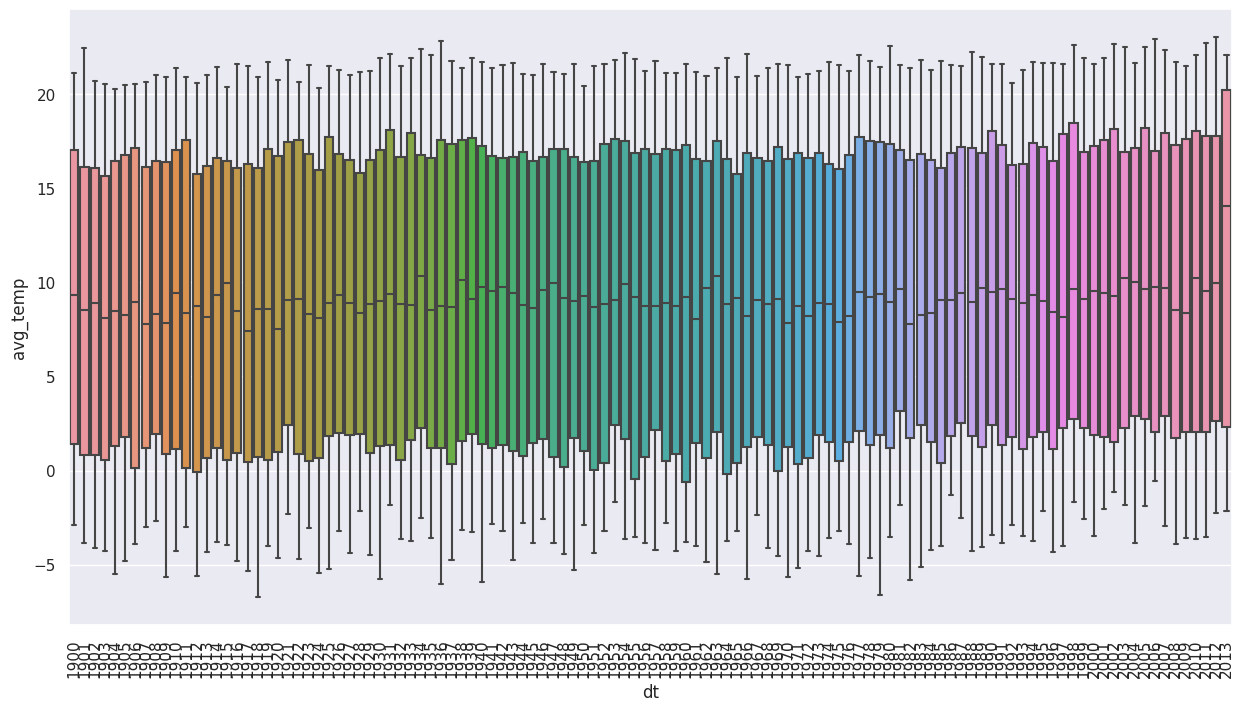

In [ ]:
#box plot

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=united_states_temp[['dt','avg_temp']], x=united_states_temp.dt.dt.year, y='avg_temp')
ax.tick_params(axis='x', labelrotation=90)



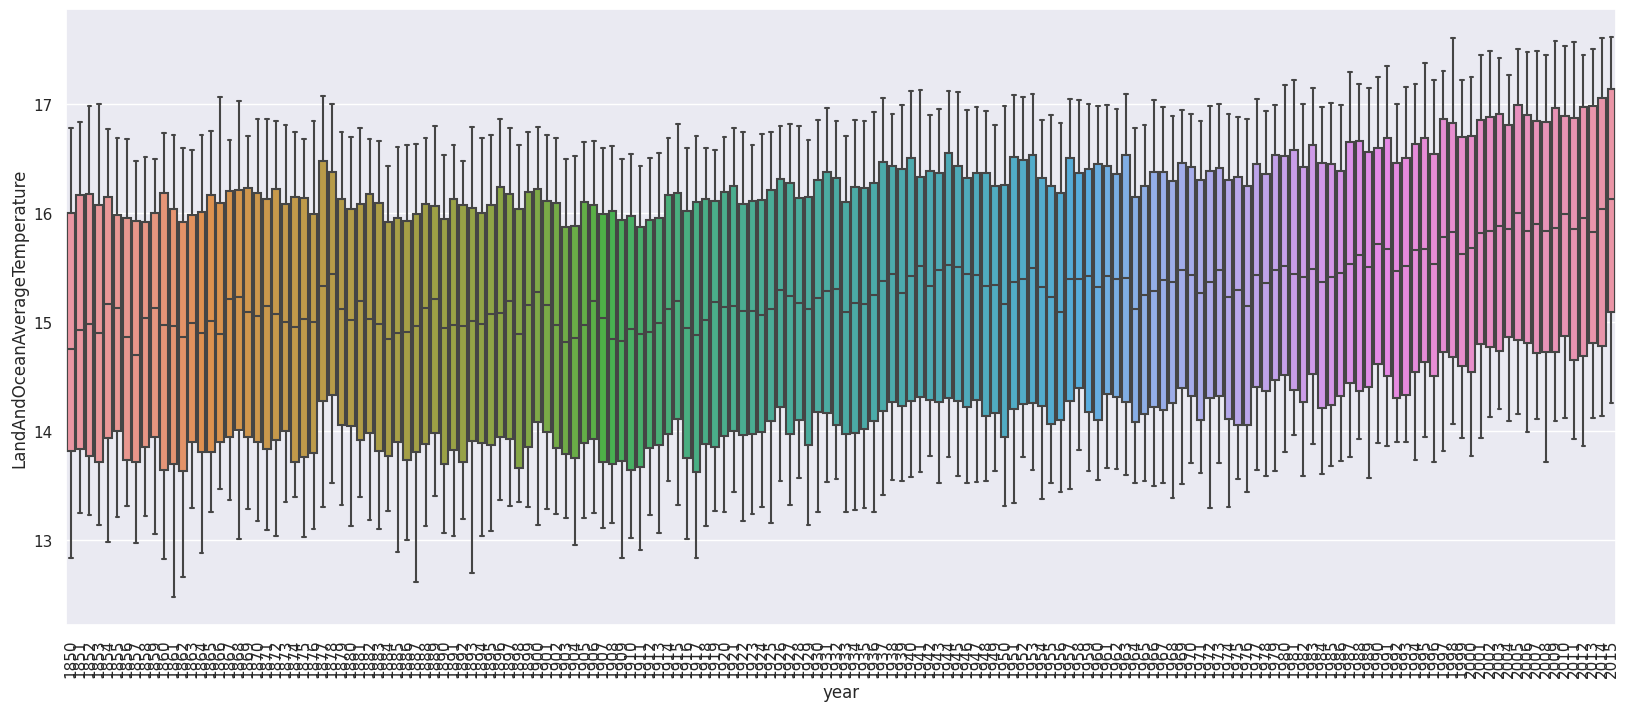

In [ ]:
temp_global_clean
plt.figure(figsize=(20,8))
ax2 = sns.boxplot(data=temp_global_clean[['year','LandAndOceanAverageTemperature']], x=temp_global_clean.year, y='LandAndOceanAverageTemperature')
ax2.tick_params(axis='x', labelrotation=90)

# **3.0 ARIMA Modle**


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# work on Arima Model

# Make prediction on test Data

# calc error

#forecast in future

import pmdarima as pm

model = pm.auto_arima(united_states_temp_arima.avg_temp, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, max_d=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model.summary())







#see if you can incorporate Sarima

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7218.932, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10797.785, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8078.774, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9184.292, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6367.892, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6375.046, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6371.732, Time=0.45 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6093.170, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6722.954, Time=0.49 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4521.125, Time=1.65 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4188.462, Time=1.77 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5992.926, Time=0.64 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=4188.506, Time=7.10 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 13.748 seconds
                    

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection

train, test = model_selection.train_test_split(united_states_temp_arima, train_size=(round(united_states_temp_arima.shape[0]*0.80)))

model= ARIMA(train, order=(3,0,3))
fit_model = model.fit()

print(fit_model.summary())



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               avg_temp   No. Observations:                 1092
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1615.565
Date:                Fri, 28 Apr 2023   AIC                           3247.130
Time:                        23:12:35   BIC                           3287.096
Sample:                    01-01-1900   HQIC                          3262.254
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8049      0.038    230.266      0.000       8.730       8.880
ar.L1          0.7343      0.039     18.626      0.000       0.657       0.812
ar.L2          0.7280      0.068     10.660      0.0

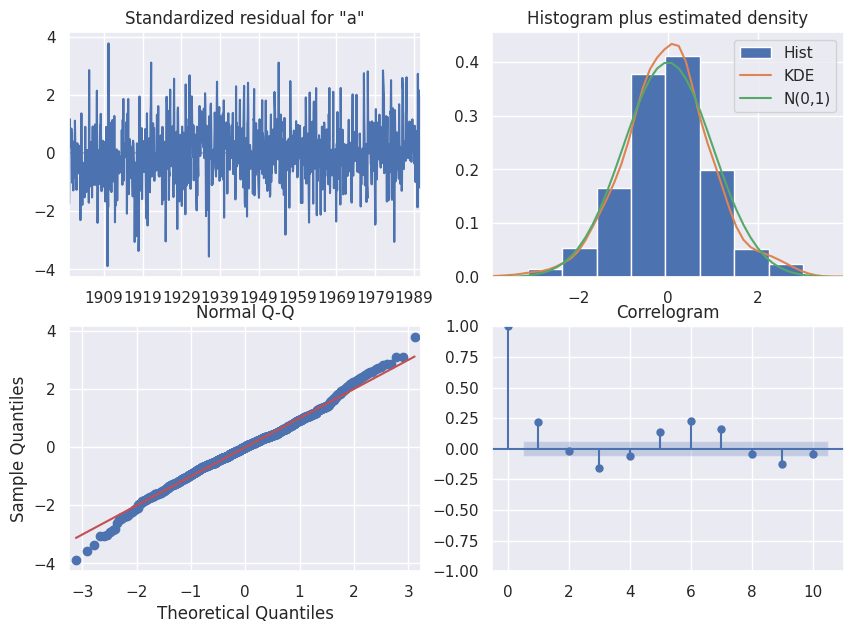

In [ ]:

fit_model.plot_diagnostics(figsize=(10,7))
plt.show()

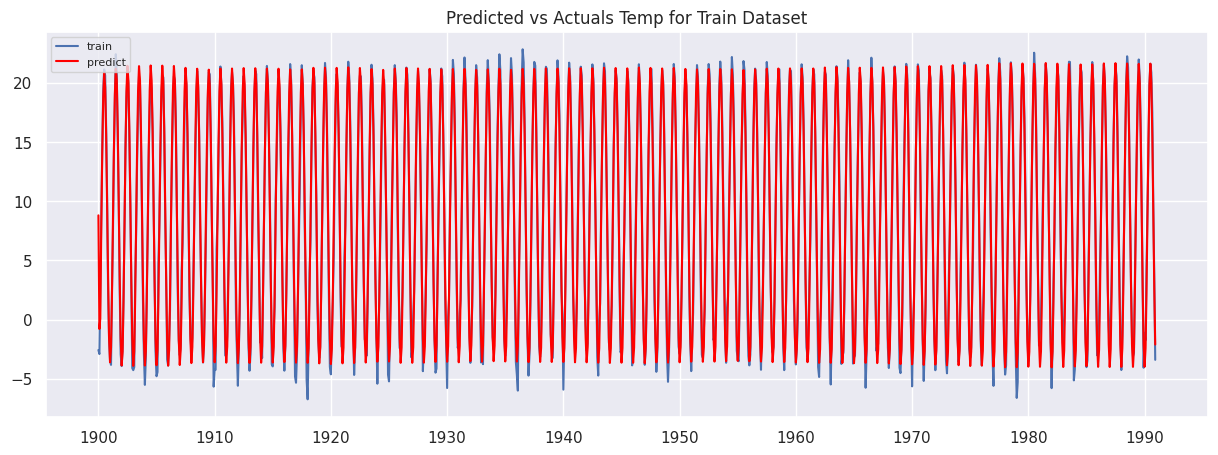

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train, label='train')
plt.plot(fit_model.fittedvalues,color='red', label='predict')
plt.title('Predicted vs Actuals Temp for Train Dataset')
plt.legend(loc='upper left', fontsize=8)

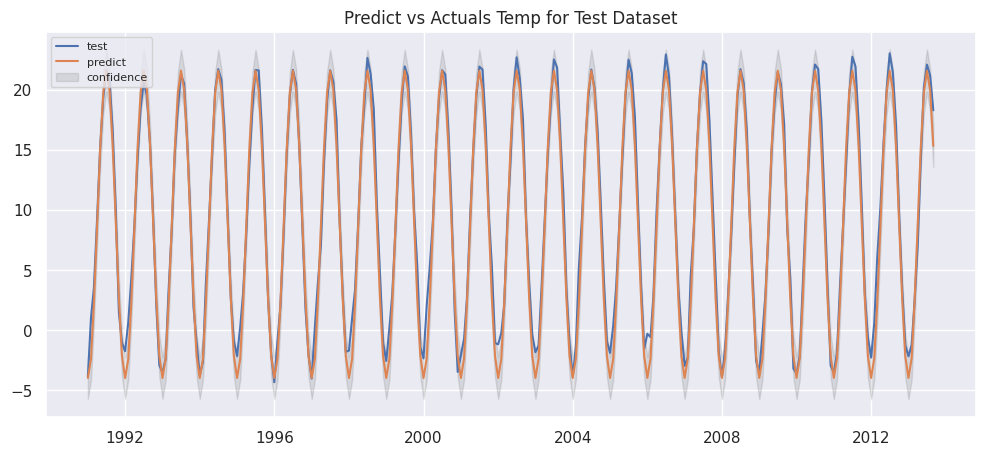

In [ ]:
#making prediction on the test data


#forecast

forecast_result = fit_model.get_forecast(steps=len(test.index), alpha=0.05)

summary_arima = forecast_result.summary_frame(alpha=0.10) #confidence of 90%

#convert results to pandas series
fc = pd.Series(summary_arima['mean'], index=test.index)
lower_interval = pd.Series(summary_arima['mean_ci_lower'], index=test.index)
upper_interval = pd.Series(summary_arima['mean_ci_upper'], index=test.index)


plt.figure(figsize=(12,5), dpi=100)

plt.plot(test, label="test")
plt.plot(fc, label="predict")
plt.fill_between(lower_interval.index, lower_interval, upper_interval,
                 color='k', alpha=.10, label='confidence')
plt.title('Predict vs Actuals Temp for Test Dataset')
plt.legend(loc='upper left', fontsize=8)




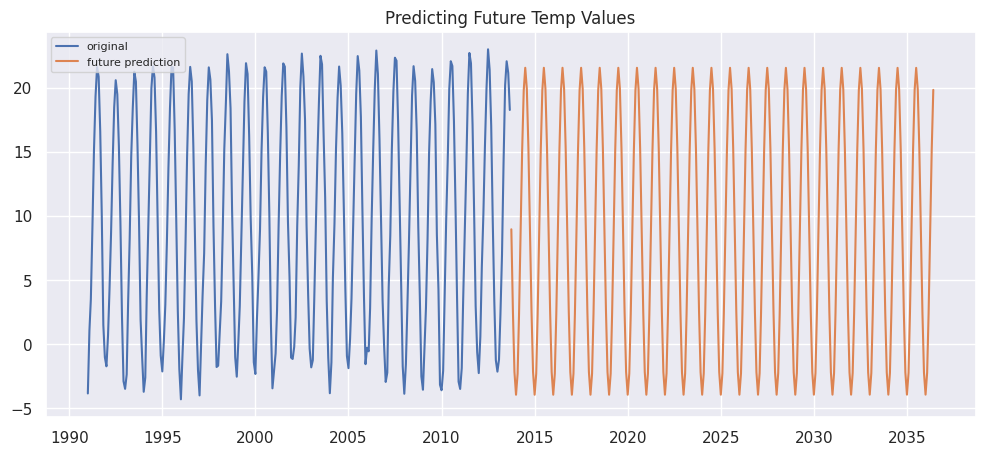

In [ ]:
#projecting into the future

futureRange = len(test.index)*2
forecast_future = fit_model.get_forecast(steps = futureRange)
future_results = forecast_future.summary_frame()
future_temp = future_results['mean']


plt.figure(figsize=(12,5), dpi=100)

plt.plot(test, label="original")
plt.plot(future_temp[len(test.index):], label="future prediction")
# plt.fill_between(lower_interval.index, lower_interval, upper_interval,
#                  color='k', alpha=.10, label='confidence')
plt.title('Predicting Future Temp Values')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
# count_disasters = geo_disasters_clean.groupby("country")[["disastertype"]].count().reset_index().rename(columns={"country": "count"})

# count_disasters

In [ ]:
temp_US = temp_north_america[temp_north_america.country == "United States of America"][['year','avg_temp']].reset_index(drop = True)
temp_US = temp_US.loc[(temp_US['year'] >= 1960) & (temp_US['year'] <= 2014)]
year  = pd.date_range(start="1960", end="2014", freq="A")
data_US = pd.Series(temp_US['avg_temp'].values,year)

model3 = pm.auto_arima(data_US, start_p=2, start_q=2,
                         # use adftest to find optimal 'd'
                      max_p=3, max_q=3, max_d=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=1,
                      start_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model3.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=64.330, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.502, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.233, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.134, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=62.835, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=61.002, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=62.831, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.329, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=69.014, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=62.233, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62.246, Time=0.16 sec
 ARIMA(1,

In [ ]:
model2= ARIMA(data_US, order=(2,1,0))
fit_model2 = model2.fit()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(data_US, label='train data')
plt.plot(fit_model2.fittedvalues,color='red', label='predictions')
plt.title('Predicted vs Actuals Temp for Train Dataset  Yearly Avg Temp')
plt.legend(loc='upper left', fontsize=8)

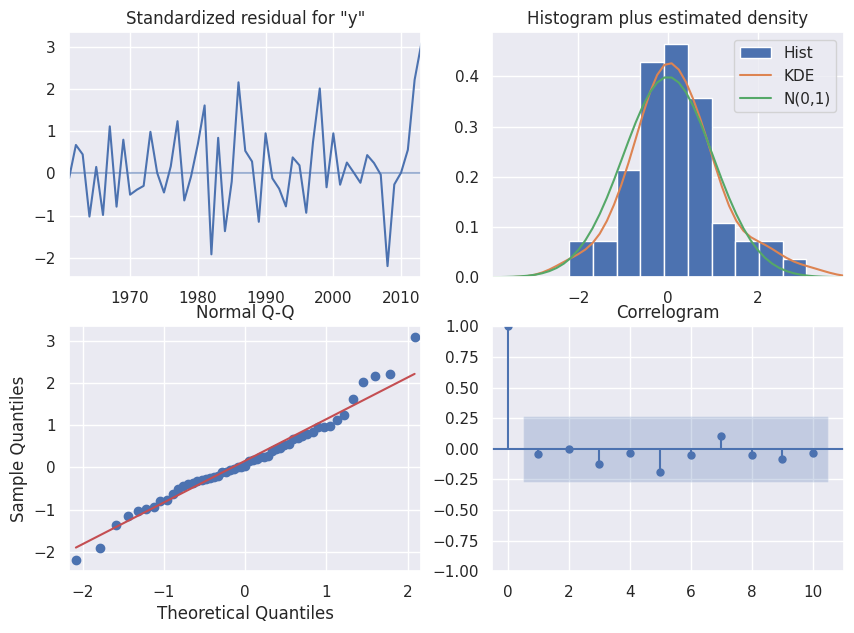

In [ ]:

fit_model2.plot_diagnostics(figsize=(10,7))
plt.show()

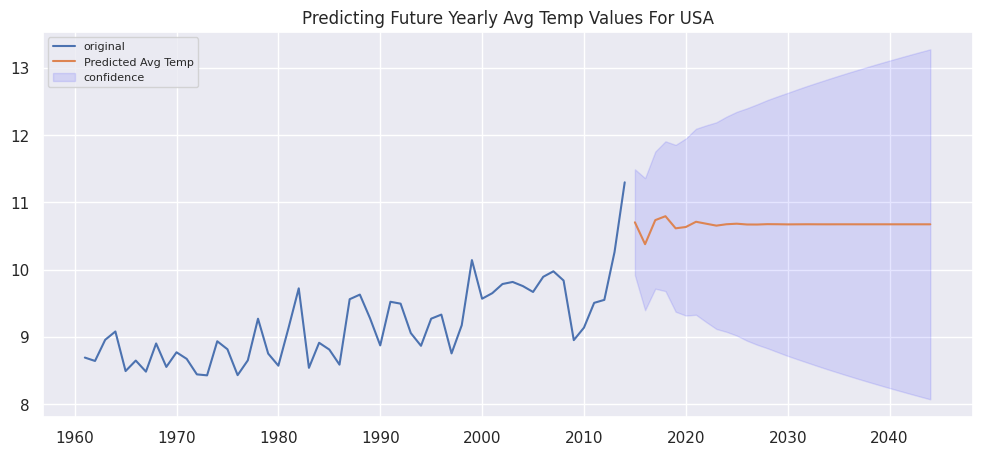

In [ ]:
futureRange = 30
forecast_future = fit_model2.get_forecast(steps = futureRange)
future_results = forecast_future.summary_frame()
future_temp = future_results['mean']


lower_interval_temp = pd.Series(future_results['mean_ci_lower'])
upper_interval_temp = pd.Series(future_results['mean_ci_upper'])


plt.figure(figsize=(12,5))

temp_plot = plt.plot(data_US, label="original")
future_temp_plot = plt.plot(future_temp, label="Predicted Avg Temp")
temp_confidence_plot = plt.fill_between(lower_interval_temp.index, lower_interval_temp, upper_interval_temp,color='blue', alpha=.10, label='confidence')
plt.title('Predicting Future Yearly Avg Temp Values For USA')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
#disaster model prediction

#geo disaster
# geo_disasters_clean2 =  geo_disasters_clean.copy()
# geo_disasters_clean2.year = geo_disasters_clean2.year.apply(lambda x: )
# count_disasters_yearly = geo_disasters_clean


count_disasters_yearly = geo_disasters_clean.groupby("year")[["disastertype"]].count().rename(columns={"disastertype": "count"})
count_disasters_yearly.index = pd.to_datetime(count_disasters_yearly.index, format='%Y')
# count_disasters_yearly

In [ ]:

dftest = adfuller(count_disasters_yearly,autolag="AIC")

dfoutput = pd.Series(dftest[0:4], index=["Test Stats", "p-value", "Lags", "observations"])
for key, value in dftest[4].items():
    dfoutput[f"Critical Value ({key})"] = value
print("Results of Dickey-Fuller Test:\n")
print(dfoutput)

print(f"Beacuse the of the p-value of {dfoutput[1]}, the data is non-stationary. We will use difference in model" )

Results of Dickey-Fuller Test:

Test Stats              -1.660916
p-value                  0.451354
Lags                    11.000000
observations            47.000000
Critical Value (1%)     -3.577848
Critical Value (5%)     -2.925338
Critical Value (10%)    -2.600774
dtype: float64
Beacuse the of the p-value of 0.4513537369901777, the data is non-stationary. We will use difference in model


In [ ]:
model_d = pm.auto_arima(count_disasters_yearly, start_p=2, start_q=2,
                         # use adftest to find optimal 'd'
                      max_p=3, max_q=3, max_d=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1,
                      start_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_d.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=777.464, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=791.506, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=777.868, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=780.406, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=789.788, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=781.560, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=779.540, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=785.555, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=776.465, Time=0.98 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=779.284, Time=1.04 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=785.554, Time=0.72 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 5.816 seconds
                               SARIMAX Results                                
Dep. Variable:           

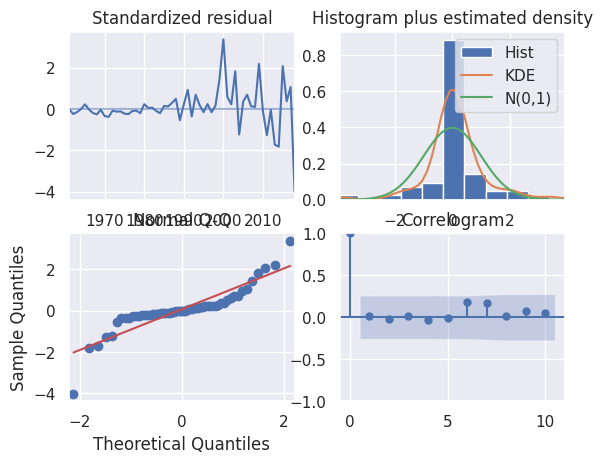

In [ ]:
model_d.plot_diagnostics()
plt.show()

In [ ]:
#ARIMA model for disaster count

#train data and predict the future

train_d, test_d = model_selection.train_test_split(count_disasters_yearly, train_size=(round(count_disasters_yearly.shape[0]*0.80)))

model_d= ARIMA(train_d, order=(2,1,2))
fit_model_d = model_d.fit()

print(fit_model_d.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   47
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -279.312
Date:                Fri, 28 Apr 2023   AIC                            568.624
Time:                        23:46:17   BIC                            577.768
Sample:                    01-01-1960   HQIC                           572.049
                         - 01-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7514      0.203     -3.710      0.000      -1.148      -0.354
ar.L2         -0.8080      0.219     -3.686      0.000      -1.238      -0.378
ma.L1          0.4808      1.436      0.335      0.7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


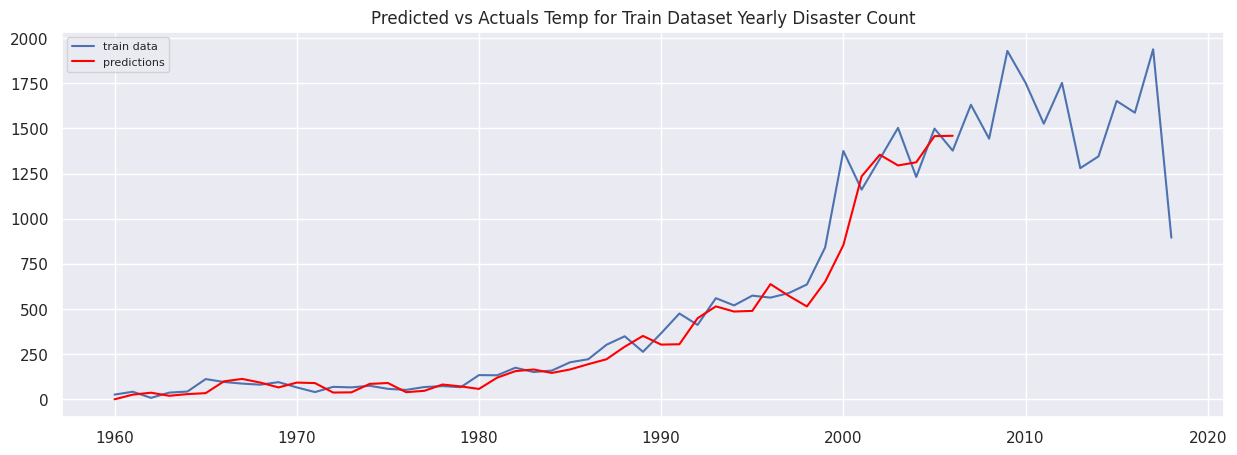

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(count_disasters_yearly, label='train data')
plt.plot(fit_model_d.fittedvalues,color='red', label='predictions')
plt.title('Predicted vs Actuals Temp for Train Dataset Yearly Disaster Count')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
len(test_d.index)

forecast_result_d = fit_model_d.get_forecast(steps=len(test_d.index), alpha=0.05)

summary_arima_d = forecast_result_d.summary_frame(alpha=0.10) #confidence of 90%
summary_arima_d['mean']

fc_d = pd.Series(summary_arima_d['mean'])
# fc_d.index = test_d.index
fc_d

2007-01-01    1253.412430
2008-01-01    1365.990848
2009-01-01    1381.268206
2010-01-01    1278.821912
2011-01-01    1343.450500
2012-01-01    1377.672129
2013-01-01    1299.737286
2014-01-01    1330.641450
2015-01-01    1370.395828
2016-01-01    1315.554548
2017-01-01    1324.636638
2018-01-01    1362.126613
Freq: AS-JAN, Name: mean, dtype: float64

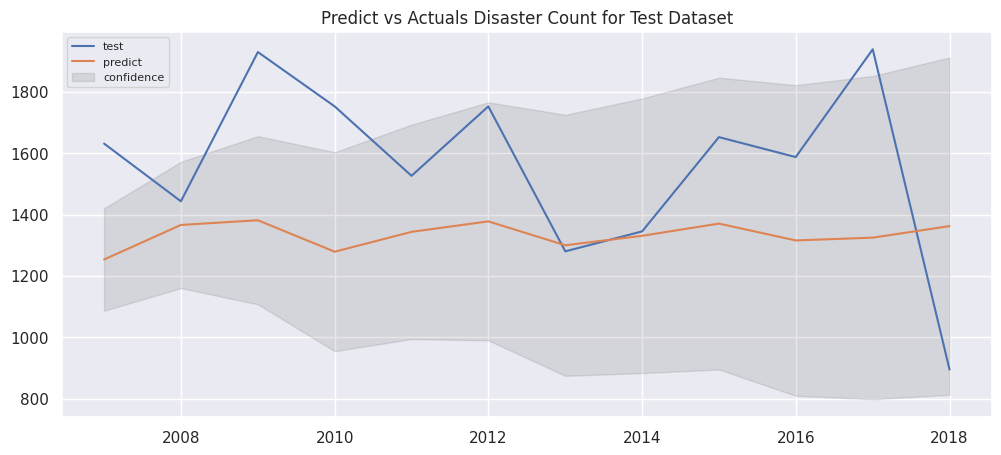

In [ ]:
#making prediction on the test data


#forecast

forecast_result_d = fit_model_d.get_forecast(steps=len(test_d.index), alpha=0.05)

summary_arima_d = forecast_result_d.summary_frame(alpha=0.10) #confidence of 90%

#convert results to pandas series
fc_d = pd.Series(summary_arima_d['mean'])
fc_d.index = test_d.index  #reset index to year

lower_interval_d = pd.Series(summary_arima_d['mean_ci_lower'])
lower_interval_d.index = test_d.index
upper_interval_d = pd.Series(summary_arima_d['mean_ci_upper'])
upper_interval_d.index = test_d.index

plt.figure(figsize=(12,5), dpi=100)

plt.plot(test_d, label="test")
plt.plot(fc_d, label="predict")
plt.fill_between(lower_interval_d.index, lower_interval_d, upper_interval_d, color='k', alpha=.10, label='confidence')
plt.title('Predict vs Actuals Disaster Count for Test Dataset')
plt.legend(loc='upper left', fontsize=8)
plt.show()

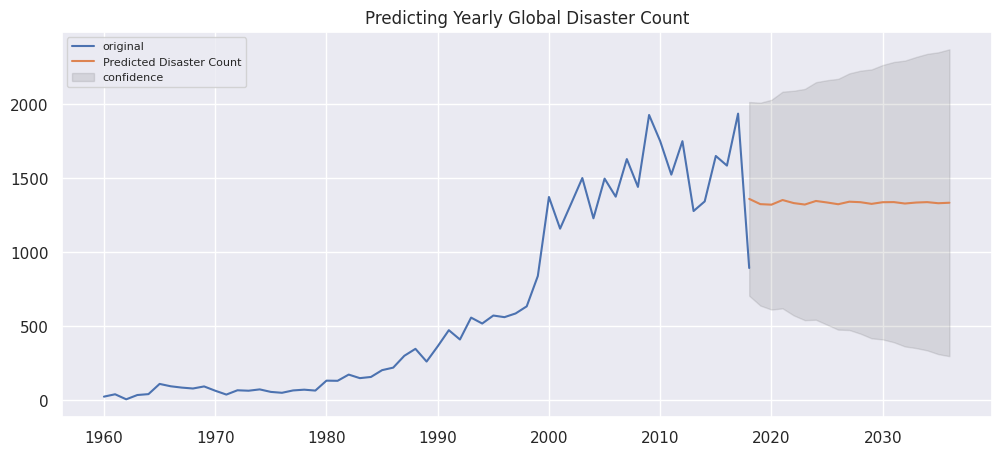

In [ ]:
futureRange = 30
forecast_future = fit_model_d.get_forecast(steps=futureRange)
future_results = forecast_future.summary_frame()
future_count = future_results['mean']

lower_interval_fc = pd.Series(future_results['mean_ci_lower'])
# lower_interval_fc.index = test_d.index
upper_interval_fc = pd.Series(future_results['mean_ci_upper'])
# upper_interval_fc.index = test_d.index


plt.figure(figsize=(12,5))

count_dis_plot = plt.plot(count_disasters_yearly, label="original")
future_dis_plot = plt.plot(future_count[len(test_d)-1:], label="Predicted Disaster Count")
dist_confidence = plt.fill_between(lower_interval_fc.index[len(test_d)-1:], lower_interval_fc[len(test_d)-1:], upper_interval_fc[len(test_d)-1:], color='k', alpha=.10, label='confidence')
plt.title('Predicting Yearly Global Disaster Count')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
disaster_count = count_disasters_yearly.squeeze()


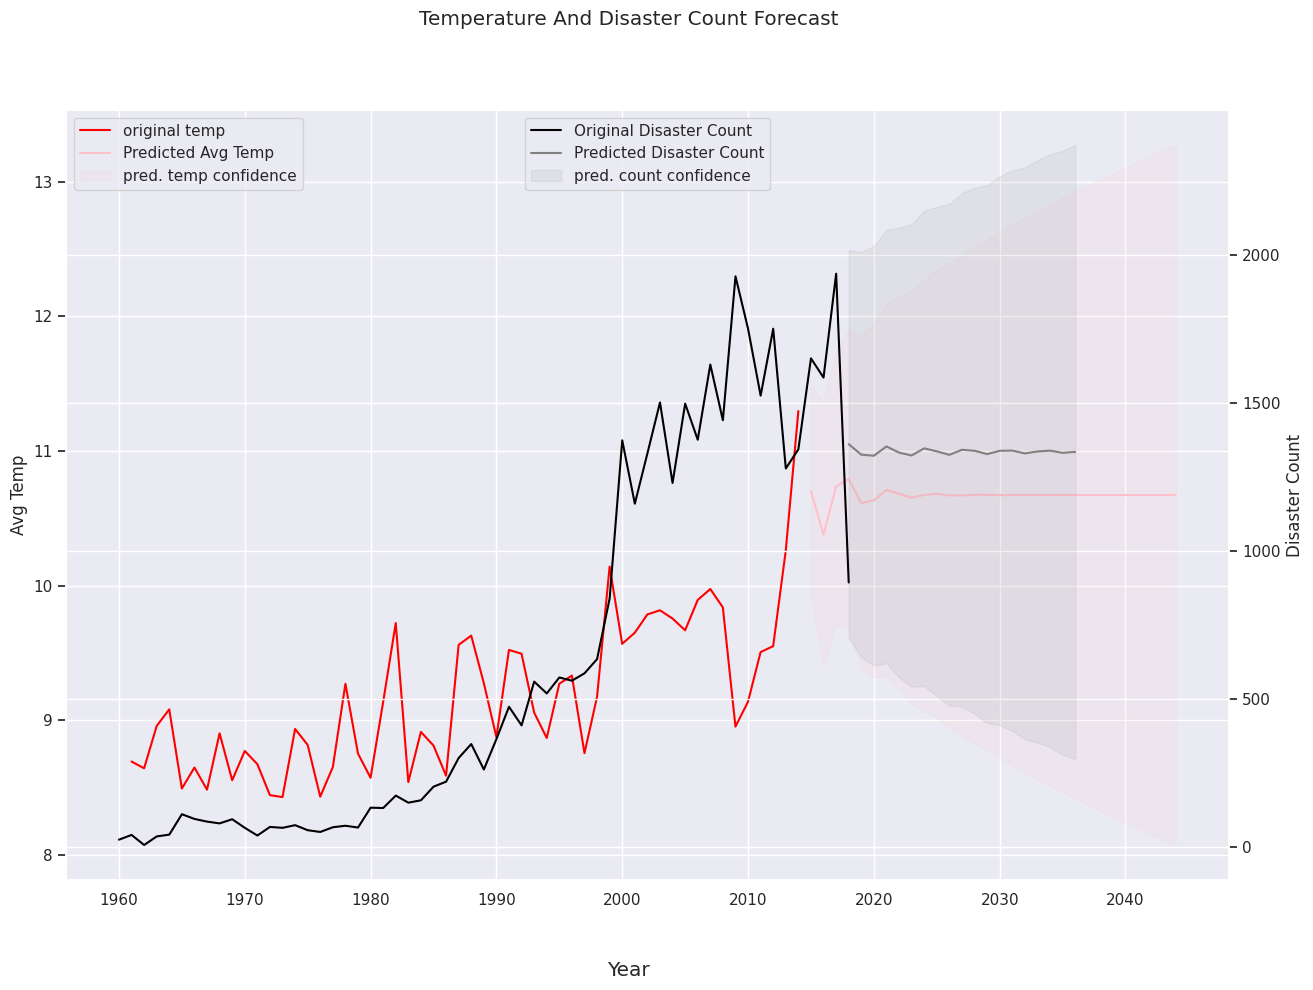

In [ ]:
fig, predict_plot = plt.subplots(sharey=False, figsize=(15,10))
plot_2 =predict_plot.twinx()
fig.suptitle("Temperature And Disaster Count Forecast")
fig.supxlabel("Year")

sns.lineplot(data_US, label="original temp", ax=predict_plot, color='red')
sns.lineplot(future_temp, label="Predicted Avg Temp", ax=predict_plot, color='pink')

predict_plot.fill_between(lower_interval_temp.index, lower_interval_temp, upper_interval_temp,color='pink', alpha=.10, label='pred. temp confidence')
predict_plot.legend(loc='upper left')
predict_plot.set_ylabel('Avg Temp')

dx = sns.lineplot(disaster_count, ax=plot_2, color='black', label='Original Disaster Count')

sns.lineplot(future_count[len(test_d)-1:], label="Predicted Disaster Count", color='grey', ax=plot_2)

plot_2.fill_between(lower_interval_fc.index[len(test_d)-1:], lower_interval_fc[len(test_d)-1:], upper_interval_fc[len(test_d)-1:], color='grey', alpha=.10, label='pred. count confidence')
plot_2.legend(loc='upper center')
plot_2.set_ylabel('Disaster Count')
plt.show()

# 2.5 Simple Exponential Smoothing Analysis: Temp Data



In [ ]:
len(temp_north_america[temp_north_america.country == "Greenland"])

114

In [ ]:
US_geo = geo_disasters_clean[geo_disasters_clean.country == 'United States of America']
US_geo = US_geo[US_geo.year.isin(range(1990,2014))]
US_geo = US_geo.groupby("year")[["disastertype"]].count().reset_index().rename(columns={"country": "count"})
US_geo

Empty DataFrame
Columns: [year, disastertype]
Index: []

In [ ]:
temp_africa
sns.lineplot(x= temp_africa[temp_africa.country == "Algeria"].year, y =temp_africa[temp_africa.country == "Algeria"].avg_temp, ax=axes[0][0])
axes[0][0].set_title("Algeria")


Text(0.5, 1.0, 'Algeria')

In [ ]:
temap = temp_north_america[temp_north_america.country == "Greenland"][['year','avg_temp']]
temap
year  = pd.date_range(start="1900", end="2014", freq="A")

<ipython-input-112-7d6e95a07f93>:8: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = Holt(data_Algeria, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.03, optimized=False)


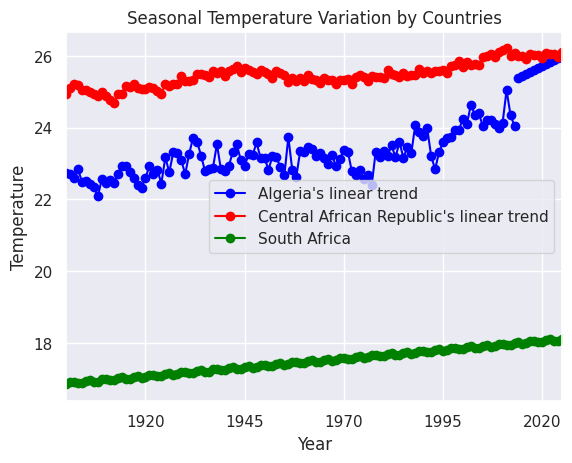

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


temp_Algeria = temp_africa[temp_africa.country == "Algeria"][['year','avg_temp']].reset_index(drop = True)
year  = pd.date_range(start="1900", end="2014", freq="A")
data_Algeria = pd.Series(temp_Algeria['avg_temp'].values,year)

fit1 = Holt(data_Algeria, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.03, optimized=False)
#ExponentialSmoothing(data_Algeria, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fcast1 = fit1.forecast(12).rename("Algeria's linear trend")

fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)

temp_Central = temp_africa[temp_africa.country == "Central African Republic"][['year','avg_temp']].reset_index(drop = True)
data_Central = pd.Series(temp_Central['avg_temp'].values,year)

fit2 = ExponentialSmoothing(data_Central, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
# Holt(data_Central, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.03, optimized=False)
fcast2 = fit2.forecast(12).rename("Central African Republic's linear trend")
fit2.fittedvalues.plot(marker="o", color='red')
fcast2.plot(color='red', marker="o", legend=True)

temp_Africa = temp_africa[temp_africa.country == "South Africa"][['year','avg_temp']].reset_index(drop = True)
data_Africa = pd.Series(temp_Africa['avg_temp'].values,year)

fit3 = ExponentialSmoothing(data_Africa, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
#Holt(data_Africa, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.03)
fcast3 = fit3.forecast(12).rename("South Africa")

fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)



plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Seasonal Temperature Variation by Countries")
plt.show()

### 4. Convolutional Neural Network Architecture


*   Using Convolutional Neural Network to predict the impact of climate change on the frequency of contries

In [ ]:
import torch
import torch.nn as nn

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: complete the constructor of the CNN class
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 48, kernel_size = 3, stride = 1, padding = 1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv2 = torch.nn.Conv2d(in_channels = 48, out_channels = 24, kernel_size = 3, stride = 1, padding = 1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(in_features = 24*8*8, out_features=168)
        self.relu3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(in_features = 168, out_features=10)


    def forward(self, x):
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.pool1(x)
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.pool2(x)
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.relu3(x)
      outputs = self.fc2(x)
      return outputs

### 4. Model Training


*   For the loss, we choose MSE or Entropy Loss.
*   We will train this dataset for 50 epochs.
*   We visualize the training loss wrt. epochs for the best model


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
batch = 64
train_loader = DataLoader(train_dataset, batch_size = batch, shuffle = True, num_workers = 0)
test_loader = DataLoader(test_dataset, batch_size = batch, shuffle = True, num_workers = 0)

%%time
# Sending the data to device (CPU or GPU)
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
# END TODO
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step
epoch = 50

acc_LIST_CNN = []
loss_LIST_CNN = []

# Train the CNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      # TODO: complete the body of this for-loop
      optimizer.zero_grad()
      # We need to reset the optimizer tensor gradient every mini-batch
      outputs = cnn(inputs)
      loss = criterion(outputs, labels) # Compute the loss
      loss.backward() # Backward pass
      optimizer.step() # Update the weight using the gradients from back propagation by learning step

      # Update the statistics
      running_loss += loss.item() #get the accumulated loss for each epoch
      predicted = outputs.argmax(dim=1)
      total += len(labels)
      correct += (predicted == labels).float().sum().detach().cpu()


  accuracy =  (correct / total)*100 # Calculate Trining Acc
  acc_LIST_CNN.append(accuracy)
  loss_LIST_CNN.append(running_loss / len(train_loader)) # get the avg loss for each epoch

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

NameError: ignored

# New Section

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # TODO

# sns.set_style('darkgrid')

# plt.plot(acc_LIST_log)
# plt.title('Training Accuracy vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Training Accuracy')

# plt.legend()

# plt.show()